# Data 102 Final Project: An Analysis of COVID-19 Vaccinations
*Created by: Armine Nersisyan, Chloe Cho, Priscilla Zhang, Rashmi Bhoj*
___
### Research Questions 
- **Casual Inference** - Does a higher median household county income level cause a higher proportion of COVID-19 vaccination?<br>
- **GLM/Non-Parametric** - Do demographics (age, race/ethnicity, and gender) predict the rate of receiving a COVID-19 vaccine?<br>
___
### Folder Hierarchy 
- ``COVID-19``: contains datasets from the COVID-19 Vaccine Progress Dashboard Data by the Calfornia Department of Public Health<br>
    - ``vaccines_county.csv``: dataset containing the daily vaccine counts for California counties<br>
    - ``vaccines_demographics.csv``: dataset containing the daily vaccine demographics for California as a whole<br>
- ``GADM USA``: contains the spatial data of administrative areas in the U.S. by GADM. Despite there being 16 files, we only use 1<br>
    - ``gadm36_USA_2.shp``: dataset containing the geometric coordinates of all administrative areas in the U.S. <br>
- ``ca_pop_sex_age.csv``: American Community Survey dataset containing estimates of the total resident population and resident population age 18 years and older for California in 2019<br>
- ``county_pop.csv``: California Department of Finance dataset containing the total population for each county in 2018<br>
- ``education.csv``: USDA Economic Research Service dataset containing the average percent of county residents that completed college in 2015-2019<br>
- ``income.csv``: American Community Survey dataset containing the median household income for each county in 2018 dollars<br>
- ``requirements.txt``: contains packages required to download<br>

In [1]:
# Import libraries and packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from datetime import datetime, timedelta
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3 as pm
from pymc3 import glm
import arviz
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestRegressor 
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from patsy.contrasts import Treatment
import scipy

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Datasets

## Income

In [2]:
"""
Income Dictionary
_________________
    key: county name
    value: 'high' if income is greater than 75235, 'low' otherwise 
"""
income_dict = {'Alameda':'high', 'Alpine':'low', 'Amador':'low', 'Butte':'low', 'Calaveras':'low', 'Colusa':'low', 'Contra Costa':'high', 
    'Del Norte':'low', 'El Dorado':'high', 'Fresno':'low', 'Glenn':'low', 'Humboldt':'low', 'Imperial':'low', 'Inyo':'low', 'Kern':'low', 
    'Kings':'low', 'Lake':'low', 'Lassen':'low', 'Los Angeles':'low', 'Madera':'low', 'Marin':'high', 'Mariposa':'low', 'Mendocino':'low', 'Merced':'low', 
    'Modoc':'low', 'Mono':'low', 'Monterey':'low', 'Napa':'high', 'Nevada':'low', 'Orange':'high', 'Placer':'high', 'Plumas':'low', 'Riverside':'low', 
    'Sacramento':'low', 'San Benito':'high', 'San Bernardino':'low', 'San Diego':'low', 'San Francisco':'high', 'San Joaquin':'low', 'San Luis Obispo':'low', 
    'San Mateo':'high', 'Santa Barbara':'low', 'Santa Clara':'high', 'Santa Cruz':'high', 'Shasta':'low', 'Sierra':'low', 'Siskiyou':'low', 'Solano':'high', 
    'Sonoma':'high', 'Stanislaus':'low', 'Sutter':'low', 'Tehama':'low', 'Trinity':'low', 'Tulare':'low', 'Tuolumne':'low', 'Ventura':'high', 'Yolo':'low', 'Yuba':'low'}

"""
Income DataFrame
_________________
    datacleaning:
        - Make 'Income' numeric
        - Rename the 'Name' column to 'county'
        - Add column for high/low income level 
    columns (4 total):
        - FIPS: (int) unique number to identify counties
        - county: (string) county name
        - Income: (float) income
        - Income Category: (string) 'high' if 'Income' is greater than 75235, 'low' otherwise
"""
income = pd.read_csv('/work/income.csv')
income['Income'] = [float(str(i).replace(",", "")) for i in income['Income']]
income = income.rename(columns={'Name':'county'})
income['Income Category'] = income['county'].map(income_dict)
income

FIPS           county    Income Income Category
0   6001          Alameda   92574.0            high
1   6003           Alpine   64688.0             low
2   6005           Amador   61198.0             low
3   6007            Butte   48443.0             low
4   6009        Calaveras   58151.0             low
5   6011           Colusa   56704.0             low
6   6013     Contra Costa   93712.0            high
7   6015        Del Norte   45258.0             low
8   6017        El Dorado   80582.0            high
9   6019           Fresno   51261.0             low
10  6021            Glenn   47395.0             low
11  6023         Humboldt   45528.0             low
12  6025         Imperial   45834.0             low
13  6027             Inyo   52874.0             low
14  6029             Kern   52479.0             low
15  6031            Kings   53865.0             low
16  6033             Lake   42475.0             low
17  6035           Lassen   56362.0             low
18  6037      Los Angeles   64251.0             low
19  6039           Madera   52884.0             low
20  6041            Marin  110217.0            high
21  6043         Mariposa   51199.0             low
22  6045        Mendocino   49233.0             low
23  6047           Merced   50129.0             low
24  6049            Modoc   45149.0             low
25  6051             Mono   63018.0             low
26  6053         Monterey   66676.0             low
27  6055             Napa   84753.0            high
28  6057           Nevada   63240.0             low
29  6059           Orange   85398.0            high
30  6061           Placer   84357.0            high
31  6063           Plumas   53270.0             low
32  6065        Riverside   63948.0             low
33  6067       Sacramento   63902.0             low
34  6069       San Benito   81977.0            high
35  6071   San Bernardino   60164.0             low
36  6073        San Diego   74855.0             low
37  6075    San Francisco  104552.0            high
38  6077      San Joaquin   61145.0             low
39  6079  San Luis Obispo   70699.0             low
40  6081        San Mateo  113776.0            high
41  6083    Santa Barbara   71657.0             low
42  6085      Santa Clara  116178.0            high
43  6087       Santa Cruz   78041.0            high
44  6089           Shasta   50905.0             low
45  6091           Sierra   48125.0             low
46  6093         Siskiyou   44200.0             low
47  6095           Solano   77609.0            high
48  6097           Sonoma   76753.0            high
49  6099       Stanislaus   57387.0             low
50  6101           Sutter   56955.0             low
51  6103           Tehama   42899.0             low
52  6105          Trinity   38497.0             low
53  6107           Tulare   47518.0             low
54  6109         Tuolumne   56493.0             low
55  6111          Ventura   84017.0            high
56  6113             Yolo   65923.0             low
57  6115             Yuba   52624.0             low

## Education

In [3]:
"""
Education Dictionary
____________________
    key: county name
    value: 'high' if % completed college is greater 35%, 'low' otherwise 
"""
education_dict = {'Alameda':'high', 'Alpine':'low', 'Amador':'low', 'Butte':'low', 'Calaveras':'low', 'Colusa':'low', 'Contra Costa':'high', 
    'Del Norte':'low', 'El Dorado':'low', 'Fresno':'low', 'Glenn':'low', 'Humboldt':'low', 'Imperial':'low', 'Inyo':'low', 'Kern':'low', 
    'Kings':'low', 'Lake':'low', 'Lassen':'low', 'Los Angeles':'low', 'Madera':'low', 'Marin':'high', 'Mariposa':'low', 'Mendocino':'low', 'Merced':'low', 
    'Modoc':'low', 'Mono':'low', 'Monterey':'low', 'Napa':'high', 'Nevada':'high', 'Orange':'high', 'Placer':'high', 'Plumas':'low', 'Riverside':'low', 
    'Sacramento':'low', 'San Benito':'low', 'San Bernardino':'low', 'San Diego':'high', 'San Francisco':'high', 'San Joaquin':'low', 'San Luis Obispo':'high', 
    'San Mateo':'high', 'Santa Barbara':'low', 'Santa Clara':'high', 'Santa Cruz':'high', 'Shasta':'low', 'Sierra':'low', 'Siskiyou':'low', 'Solano':'low', 
    'Sonoma':'high', 'Stanislaus':'low', 'Sutter':'low', 'Tehama':'low', 'Trinity':'low', 'Tulare':'low', 'Tuolumne':'low', 'Ventura':'low', 'Yolo':'high', 'Yuba':'low'}

"""
Education DataFrame
____________________
    datacleaning:
        - Make % completed college column numeric
        - Rename the county column 
        - Select for desired columns
        - Add column for high/low education level
    columns (4 total):
        - FIPS: (int) unique number to identify counties
        - county: (string) county name
        - % college graduates: (float) percentage of college graduates in a county
        - Education Category: (string) 'high' if '% college educates' is greater than 35, 'low' otherwise
"""
education = pd.read_csv('/work/education.csv')
education['2015-2019'] = [float(str(i).replace("%", "")) for i in education['2015-2019']]
education = education.rename(columns={'Name':'county','2015-2019':'% college graduates'})[['FIPS','county','% college graduates']]
education['Education Category'] = education['county'].map(education_dict)
education

FIPS           county  % college graduates Education Category
0   6001          Alameda                 47.4               high
1   6003           Alpine                 34.5                low
2   6005           Amador                 19.3                low
3   6007            Butte                 27.2                low
4   6009        Calaveras                 18.3                low
5   6011           Colusa                 15.0                low
6   6013     Contra Costa                 42.4               high
7   6015        Del Norte                 14.8                low
8   6017        El Dorado                 34.3                low
9   6019           Fresno                 21.2                low
10  6021            Glenn                 14.2                low
11  6023         Humboldt                 30.4                low
12  6025         Imperial                 15.2                low
13  6027             Inyo                 27.2                low
14  6029             Kern                 16.4                low
15  6031            Kings                 14.7                low
16  6033             Lake                 15.5                low
17  6035           Lassen                 12.9                low
18  6037      Los Angeles                 32.5                low
19  6039           Madera                 14.6                low
20  6041            Marin                 59.5               high
21  6043         Mariposa                 24.6                low
22  6045        Mendocino                 24.4                low
23  6047           Merced                 13.8                low
24  6049            Modoc                 15.2                low
25  6051             Mono                 28.8                low
26  6053         Monterey                 24.7                low
27  6055             Napa                 35.7               high
28  6057           Nevada                 37.2               high
29  6059           Orange                 40.6               high
30  6061           Placer                 39.7               high
31  6063           Plumas                 23.7                low
32  6065        Riverside                 22.3                low
33  6067       Sacramento                 30.9                low
34  6069       San Benito                 19.7                low
35  6071   San Bernardino                 21.0                low
36  6073        San Diego                 38.8               high
37  6075    San Francisco                 58.1               high
38  6077      San Joaquin                 18.8                low
39  6079  San Luis Obispo                 35.4               high
40  6081        San Mateo                 51.0               high
41  6083    Santa Barbara                 34.2                low
42  6085      Santa Clara                 52.4               high
43  6087       Santa Cruz                 40.8               high
44  6089           Shasta                 22.2                low
45  6091           Sierra                 17.9                low
46  6093         Siskiyou                 23.2                low
47  6095           Solano                 26.9                low
48  6097           Sonoma                 35.5               high
49  6099       Stanislaus                 17.1                low
50  6101           Sutter                 18.2                low
51  6103           Tehama                 15.7                low
52  6105          Trinity                 19.5                low
53  6107           Tulare                 14.6                low
54  6109         Tuolumne                 20.5                low
55  6111          Ventura                 33.8                low
56  6113             Yolo                 41.4               high
57  6115             Yuba                 17.1                low

## Vaccinations by County

In [4]:
"""
County Vaccinations Dataframe
_________
    datacleaning:
        - Added 'education_level' column for high/low education
        - Added 'income-level' column for high/low income
        - Select for desired columns
        - Remove aggregate rows
    columns (9 total):
        - county: (string) county name
        - administered_date: (datetime) reporting date
        - fully_vaccinated: (int) number of people fully vaccinated that day
        - cumulative_fully_vaccinated: (int) total number of people fully vaccinated up to that day
        - education_level: (string) 'high' if % completed college is greater 35%, 'low' otherwise 
        - income_level: (string) 'high' if median household income is greater than 75235, 'low' otherwise
        - pfizer_doses: (int) total number of Pfizer doses that day
        - moderna_doses: (int) total number of Moderna doses that day
        - jj_doses: (int) total number of Johnson & Johnson doses that day
        
"""
county_vax = pd.read_csv('/work/COVID-19/vaccines_county.csv')
county_vax['education_level'] = county_vax['county'].map(education_dict)
county_vax['income_level'] = county_vax['county'].map(income_dict)
county_vax = county_vax[['county', 'administered_date', 'fully_vaccinated','cumulative_fully_vaccinated','education_level','income_level',"pfizer_doses", "moderna_doses", "jj_doses"]]
county_vax = county_vax[(county_vax['county']!='All CA Counties') & (county_vax['county']!='All CA and Non-CA Counties') & (county_vax['county']!='Outside California') & (county_vax['county']!='Unknown')]
county_vax

county administered_date  fully_vaccinated  \
546   Alameda        2020-12-15                 0   
547   Alameda        2020-12-16                 0   
548   Alameda        2020-12-17                 0   
549   Alameda        2020-12-18                 0   
550   Alameda        2020-12-19                 0   
...       ...               ...               ...   
8307     Yuba        2021-04-28               275   
8308     Yuba        2021-04-29               239   
8309     Yuba        2021-04-30               144   
8310     Yuba        2021-05-01                76   
8311     Yuba        2021-05-02                12   

      cumulative_fully_vaccinated education_level income_level  pfizer_doses  \
546                             0            high         high            36   
547                             0            high         high           203   
548                             0            high         high           396   
549                             0            high         high          1769   
550                             0            high         high          1355   
...                           ...             ...          ...           ...   
8307                        14457             low          low           168   
8308                        14696             low          low            25   
8309                        14840             low          low            48   
8310                        14916             low          low            32   
8311                        14928             low          low            17   

      moderna_doses  jj_doses  
546               0         0  
547               0         0  
548               0         0  
549               0         0  
550               0         0  
...             ...       ...  
8307            242         5  
8308            316         2  
8309            165        28  
8310             66        18  
8311              8         3  

[7766 rows x 9 columns]

## Vaccinations by State Demographics

In [5]:
"""
Vaccine State Demographics DataFrame
_________
    datacleaning:
        - Convert 'administered_date' to datetime object
        - Create a column indicating which phase the date falls under
        - Select for desired columns
    columns (10 total):
        - demographic_category: (string) the demographic category
        - demographic_value: (string) the value of the demographic category
        - administered_date: (datetime) reporting date
        - total_doses: (int) total number of doses that day, regardless of vaccine type
        - moderna_doses: (int) total number of Moderna doses that day
        - pfizer_doses: (int) total number of Pfizer doses that day
        - jj_doses: (int) total number of Johnson & Johnson doses that day
        - fully_vaccinated: (int) number of people fully vaccinated that day
        - cumulative_fully_vaccinated: (int) total number of people fully vaccinated up to that day
        - phase: (string) the phase in which the date falls under
"""
dem_vax = pd.read_csv('/work/COVID-19/vaccines_demographics.csv')
dem_vax['administered_date'] = pd.to_datetime(dem_vax['administered_date'])

phases = []
for i in dem_vax["administered_date"]:
    if i < pd.to_datetime("01-18-2021"):
        phases.append("1A")
    elif (i >= pd.to_datetime("01-18-2021") and i < pd.to_datetime("03-15-2021")):
        phases.append("1B")
    elif (i >= pd.to_datetime("03-15-2021") and i < pd.to_datetime("03-23-2021")):
        phases.append("1C")
    elif (i >= pd.to_datetime("03-23-2021") and i < pd.to_datetime("03-30-2021")):
        phases.append("2A")
    elif (i >= pd.to_datetime("03-30-2021") and i < pd.to_datetime("04-12-2021")):
        phases.append("2B")
    elif i >= pd.to_datetime("04-12-2021") :
        phases.append("2C/3")
dem_vax["phase"] = phases
dem_vax = dem_vax[['demographic_category','demographic_value','administered_date','total_doses','moderna_doses',"pfizer_doses", 'jj_doses','fully_vaccinated','cumulative_fully_vaccinated','phase']]
dem_vax

demographic_category                          demographic_value  \
0               Age Group                                      18-49   
1               Age Group                                        65+   
2               Age Group                                      50-64   
3               Age Group                                       0-17   
4               Age Group                           Unknown Agegroup   
...                   ...                                        ...   
2354       Race/Ethnicity                                    Unknown   
2355       Race/Ethnicity                  Black or African American   
2356       Race/Ethnicity                                Multiracial   
2357       Race/Ethnicity  Native Hawaiian or Other Pacific Islander   
2358       Race/Ethnicity           American Indian or Alaska Native   

     administered_date  total_doses  moderna_doses  pfizer_doses  jj_doses  \
0           2021-05-02        34029           7416         25957       656   
1           2021-05-02         2556            749          1741        66   
2           2021-05-02        15420           4537         10573       310   
3           2021-05-02         3750              1          3748         1   
4           2021-05-02            4              1             3         0   
...                ...          ...            ...           ...       ...   
2354        2020-12-15           54              0            54         0   
2355        2020-12-15           52              0            52         0   
2356        2020-12-15           23              0            23         0   
2357        2020-12-15           14              0            14         0   
2358        2020-12-15            3              0             3         0   

      fully_vaccinated  cumulative_fully_vaccinated phase  
0                18780                      5235062  2C/3  
1                 1430                      4026291  2C/3  
2                10660                      3507471  2C/3  
3                 1616                        89977  2C/3  
4                    0                          319  2C/3  
...                ...                          ...   ...  
2354                 0                            0    1A  
2355                 0                            0    1A  
2356                 0                            0    1A  
2357                 0                            0    1A  
2358                 0                            0    1A  

[2359 rows x 10 columns]

# EDA

## Question 1

### Scatter Plot: Education vs Income

Our first exploratory graph is a scatter plot, with a line of best fit that demonstrates the positive relationship between income and education. According to the calculated $R^{2}$ value of 0.7444, income and education have a strong relationship. 

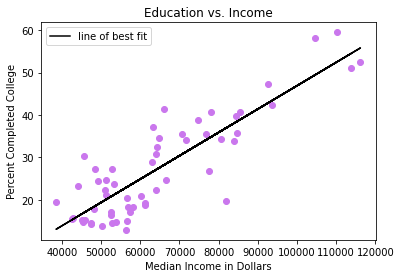

About 74.44% of the variation in education can be explained using income.


In [6]:
X = income['Income']
Y = education['% college graduates']
m, b = np.polyfit(X, Y, 1)
Y_pred = m*X+b

plt.scatter(X, Y, color='#ca77ed')
plt.plot(X, Y_pred, color='black', label='line of best fit')
plt.xlabel('Median Income in Dollars')
plt.ylabel('Percent Completed College')
plt.title('Education vs. Income')
plt.legend()
plt.show()

res = Y - Y_pred
tot = Y - Y.mean()
R_squared = 1 - res.dot(res)/tot.dot(tot)
R_squared_converted = round(R_squared*100,2)
print("About {}% of the variation in education can be explained using income.".format(R_squared_converted))

### Scatter Plot: Vaccine Rate vs Education

Our second exploratory graph is also a scatter plot with a line of best fit, demonstrating the positive relationship between education and vaccination rate per county. According to the calculated $R^{2}$ value of 0.5686, education and vaccination rate have a moderate relationship. 

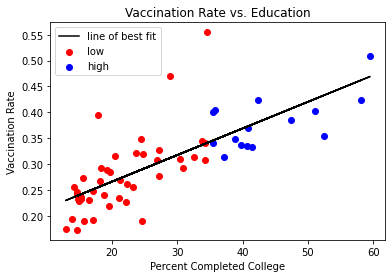

About 56.86% of the variation in vaccination rate can be explained using education.


In [7]:
vax_edu = education.merge(county_vax.groupby("county").sum(), on="county", how="left")
vax_edu["population"] = [1662775, 1141, 38063, 227837, 44637, 22744, 1145876, 27275, 188993, 1010926, 29337, 135627, 189468, 18526, 907518, 153540, 65170, 30563, 10278836, 158259, 262224, 17918, 89027, 280772, 9505, 13887, 443819, 140491, 98719, 3216817, 389047, 19517, 2419897, 1534893, 61260, 2178492, 3344430, 887540, 759186, 279370, 774159, 453288, 1956579, 275221, 178262, 3153, 44082, 439472, 501427, 554703, 98735, 64532, 13407, 476909, 52790, 855489, 221557, 77494]
cols = ['red' if (x < 35) else 'C0' for x in education['% college graduates']]


vax_edu_low = vax_edu[vax_edu['% college graduates'] < 35]
vax_edu_high = vax_edu[vax_edu['% college graduates'] >= 35]

X = vax_edu['% college graduates']
X_low = vax_edu_low['% college graduates']
X_high = vax_edu_high['% college graduates']

Y = vax_edu['fully_vaccinated']/vax_edu['population']
Y_low = vax_edu_low['fully_vaccinated']/vax_edu_low['population']
Y_high = vax_edu_high['fully_vaccinated']/vax_edu_high['population']

m, b = np.polyfit(X, Y, 1)
Y_pred = m*X+b

fig, ax = plt.subplots()
plt.scatter(X_low, Y_low, color='red', label='low')
plt.scatter(X_high, Y_high, color='blue', label='high')
plt.plot(X, Y_pred, color='black', label='line of best fit')
plt.ylabel("Vaccination Rate")
plt.xlabel("Percent Completed College")
plt.title("Vaccination Rate vs. Education")
plt.legend()
plt.show()

res = Y - Y_pred
tot = Y - Y.mean()

R_squared = 1 - res.dot(res)/tot.dot(tot)
R_squared_converted = round(R_squared*100,2)
print("About {}% of the variation in vaccination rate can be explained using education.".format(R_squared_converted))

### Scatter Plot: Vaccine Rate vs Income

The following graph is similar to the previous one, except it demonstrates the positive relationship between *income* and vaccination rate. According to the calculated $R^{2}$ value of 0.4102, income and vacination rate have a moderate relationship. 

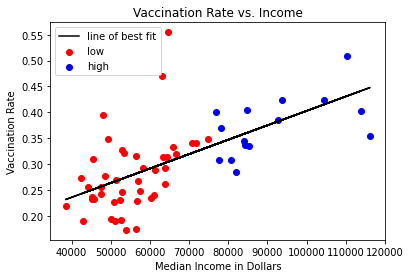

About 41.02% of the variation in vaccination rate can be explained using income.


In [8]:
vax_inc = income.merge(county_vax.groupby("county").sum(), on="county", how="left")
vax_inc["population"] = [1662775, 1141, 38063, 227837, 44637, 22744, 1145876, 27275, 188993, 1010926, 29337, 135627, 189468, 18526, 907518, 153540, 65170, 30563, 10278836, 158259, 262224, 17918, 89027, 280772, 9505, 13887, 443819, 140491, 98719, 3216817, 389047, 19517, 2419897, 1534893, 61260, 2178492, 3344430, 887540, 759186, 279370, 774159, 453288, 1956579, 275221, 178262, 3153, 44082, 439472, 501427, 554703, 98735, 64532, 13407, 476909, 52790, 855489, 221557, 77494]
cols = ['red' if (x < 75235) else 'C0' for x in income['Income']]

vax_inc_low = vax_inc[vax_inc['Income'] < 75235]
vax_inc_high = vax_inc[vax_inc['Income'] >= 75235]

X = vax_inc['Income']
X_low = vax_inc_low['Income']
X_high = vax_inc_high['Income']

Y = vax_inc['fully_vaccinated']/vax_inc['population']
Y_low = vax_inc_low['fully_vaccinated']/vax_inc_low['population']
Y_high = vax_inc_high['fully_vaccinated']/vax_inc_high['population']

m, b = np.polyfit(X, Y, 1)
Y_pred = m*X+b

fig, ax = plt.subplots()
plt.scatter(X_low, Y_low, color='red', label='low')
plt.scatter(X_high, Y_high, color='blue', label='high')
plt.plot(X, Y_pred, color='black', label='line of best fit')
plt.ylabel("Vaccination Rate")
plt.xlabel("Median Income in Dollars")
plt.title("Vaccination Rate vs. Income")
plt.legend()
plt.show()

res = Y - Y_pred
tot = Y - Y.mean()

R_squared = 1 - res.dot(res)/tot.dot(tot)
R_squared_converted = round(R_squared*100,2)
print("About {}% of the variation in vaccination rate can be explained using income.".format(R_squared_converted))

### Bar Chart: Sorted Income by County

With this bar chart, where counties are split above and below a median income of $75,235, we see that there are less counties with a high median income (blue) than a low median income (red).

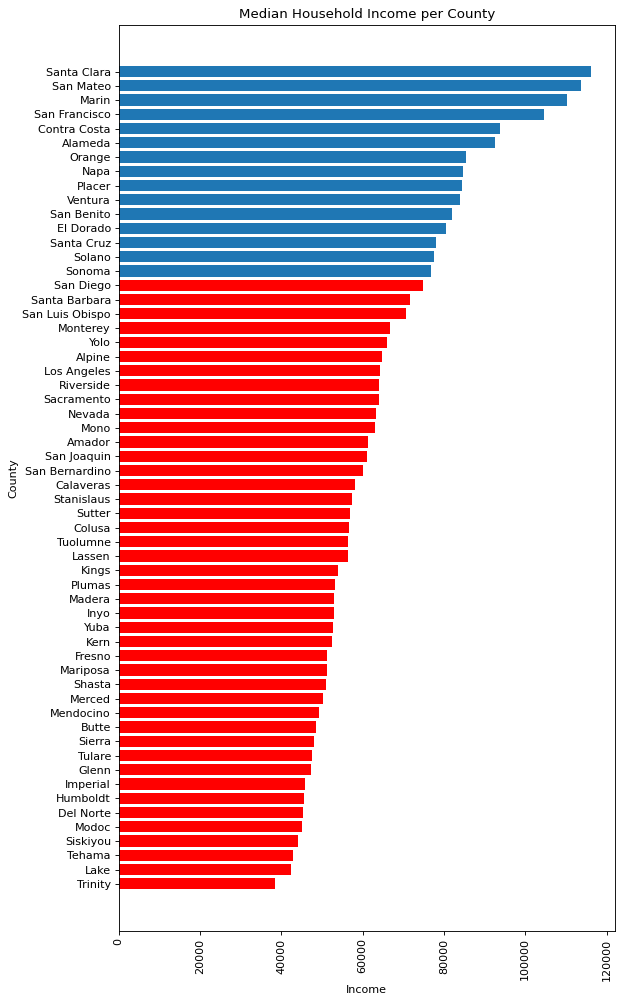

In [9]:
# bar chart for income per county, split into above and below average state household income
sorted_income = income.sort_values('Income', ascending=True)

col = ['red' if (x < 75235) else 'C0' for x in sorted_income['Income']]
plt.figure(figsize=(8, 15), dpi=80)
plt.barh(sorted_income['county'], sorted_income['Income'], color=col)
plt.xticks(rotation=90)
plt.xlabel('Income')
plt.ylabel('County')
plt.title('Median Household Income per County');

### Bar Chart: Sorted Education by County

With this bar chart, where counties are split above and below a 35% percent of residents having completed college, we see that there are less counties with high education (blue) than low education (red). Compared to the previous bar chart, there is overlap in the high education and high income counties and, consequently, overlap in the low education and low income counties.

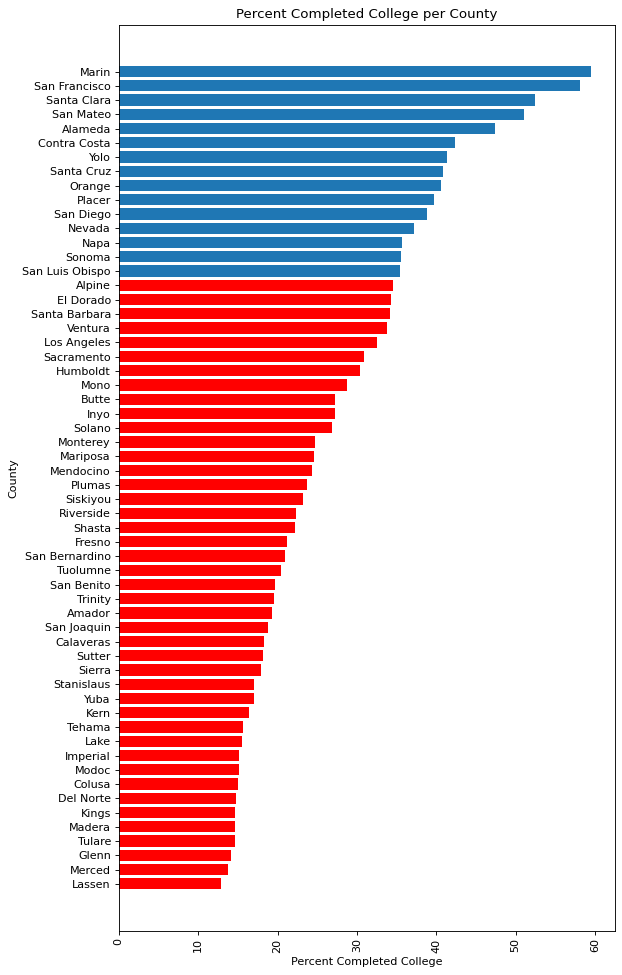

In [10]:
# bar chart for education level per county, split into above and below 35% threshold 
sorted_education = education.sort_values('% college graduates', ascending=True)

col = ['red' if (x < 35) else 'C0' for x in sorted_education['% college graduates']]
plt.figure(figsize=(8, 15), dpi=80)
plt.barh(sorted_education['county'], sorted_education['% college graduates'], color=col)
plt.xticks(rotation=90)
plt.xlabel('Percent Completed College')
plt.ylabel('County')
plt.title('Percent Completed College per County');

### Scatter Plot: Income vs Vaccine Rate, Conditioned on Vaccine Type

Taking advantage of the columns that specify the total number of doses administered that day for a certain vaccine, we visualize the relationship between income and vaccination rate based on the type of vaccine. We made sure to consider the fact that the Johnson &amp; Johnson vaccine only requires a single dose for a person to be considered "fully vaccinated," whereas Pfizer and Moderna require two doses. 

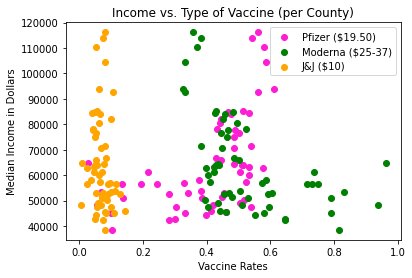

In [11]:
vax_prices = pd.DataFrame({"Pfizer":19.5, "Moderna":np.average([25,37]), "Johnson & Johnson":10}, index=["Price per Dose"])
county_vax_grouped = county_vax.groupby("county", as_index=False).sum()
income_county_vax = pd.merge(county_vax_grouped, income, on=["county"])
income_county_vax = income_county_vax[["county", "pfizer_doses", "moderna_doses", "jj_doses", "Income", "Income Category"]]

pfizer_rate = []
moderna_rate = []
jj_rate = []

for i in income_county_vax["county"]:
    
    one = income_county_vax[income_county_vax["county"] == i]["pfizer_doses"]/2
    two = income_county_vax[income_county_vax["county"] == i]["moderna_doses"]/2
    three = income_county_vax[income_county_vax["county"] == i]["jj_doses"]
    total = one + two + three
    pfizer_rate.append(one/total)
    moderna_rate.append(two/total)
    jj_rate.append(three/total)

income_county_vax["pfizer_rate"] = pfizer_rate
income_county_vax["moderna_rate"] = moderna_rate
income_county_vax["jj_rate"] = jj_rate

plt.scatter(income_county_vax["pfizer_rate"], income_county_vax["Income"], color="#fc1ed4")
plt.scatter(income_county_vax["moderna_rate"], income_county_vax["Income"], color="g")
plt.scatter(income_county_vax["jj_rate"], income_county_vax["Income"], color="orange")
plt.ylabel("Median Income in Dollars")
plt.xlabel("Vaccine Rates")

plt.title("Income vs. Type of Vaccine (per County)")
plt.legend(["Pfizer ($19.50)", "Moderna ($25-37)", "J&J ($10)"])
plt.show()

### Scatter Plot: Education vs Vaccine Rate, Conditioned on Vaccine Type

With this next scatter plot, we follow the same idea as before, except we visualize the relationship between education and vaccination rate based on the type of vaccine. We also made sure to consider the fact that the Johnson &amp; Johnson vaccine only requires a single dose for a person to be considered "fully vaccinated," whereas Pfizer and Moderna require two doses.

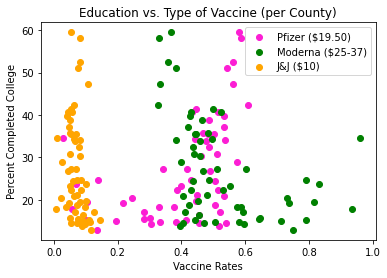

In [12]:
#plot comparison between vaccine prices and education
vax_prices = pd.DataFrame({"Pfizer":19.5, "Moderna":np.average([25,37]), "Johnson & Johnson":10}, index=["Price per Dose"])
county_vax_grouped = county_vax.groupby("county", as_index=False).sum()
education_county_vax = pd.merge(county_vax_grouped, education, on=["county"])
education_county_vax = education_county_vax[["county", "pfizer_doses", "moderna_doses", "jj_doses", "% college graduates", "Education Category"]]

pfizer_rate = []
moderna_rate = []
jj_rate = []

for i in education_county_vax["county"]:
    
    one = education_county_vax[education_county_vax["county"] == i]["pfizer_doses"]/2
    two = education_county_vax[education_county_vax["county"] == i]["moderna_doses"]/2
    three = education_county_vax[education_county_vax["county"] == i]["jj_doses"]
    total = one + two + three
    pfizer_rate.append(one/total)
    moderna_rate.append(two/total)
    jj_rate.append(three/total)

education_county_vax["pfizer_rate"] = pfizer_rate
education_county_vax["moderna_rate"] = moderna_rate
education_county_vax["jj_rate"] = jj_rate

plt.scatter(education_county_vax["pfizer_rate"], education_county_vax["% college graduates"], color="#fc1ed4")
plt.scatter(education_county_vax["moderna_rate"], education_county_vax["% college graduates"], color="g")
plt.scatter(education_county_vax["jj_rate"], education_county_vax["% college graduates"], color="orange")
plt.ylabel("Percent Completed College")
plt.xlabel("Vaccine Rates")

plt.title("Education vs. Type of Vaccine (per County)")
plt.legend(["Pfizer ($19.50)", "Moderna ($25-37)", "J&J ($10)"])
plt.show()

### Choropleth Map

After getting the FIPS codes in the correct format, we used Plotly to create interactive choropleth map of the United States. Adjusting for a certain date, we can visualize vaccinations data for California counties. What we want to show here is that there are some empty spots on the map for this particular day. The California counties with missing data on that day are colored as gray, like the other states. You are unable to hover over those counties, indicating that there might be missing data.

In [13]:
income_copy = income.copy()
income_copy['FIPS'] = income_copy['FIPS'].apply(lambda x: '0'+str(x))
merged_interactive = county_vax.merge(income_copy, on='county')
merged_interactive.head()

county administered_date  fully_vaccinated  cumulative_fully_vaccinated  \
0  Alameda        2020-12-15                 0                            0   
1  Alameda        2020-12-16                 0                            0   
2  Alameda        2020-12-17                 0                            0   
3  Alameda        2020-12-18                 0                            0   
4  Alameda        2020-12-19                 0                            0   

  education_level income_level  pfizer_doses  moderna_doses  jj_doses   FIPS  \
0            high         high            36              0         0  06001   
1            high         high           203              0         0  06001   
2            high         high           396              0         0  06001   
3            high         high          1769              0         0  06001   
4            high         high          1355              0         0  06001   

    Income Income Category  
0  92574.0            high  
1  92574.0            high  
2  92574.0            high  
3  92574.0            high  
4  92574.0            high

In [14]:
from urllib.request import urlopen
import json, geojson,subprocess
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import plotly.express as px

# Cumulative fully vaccinated on a particular day
date = merged_interactive['administered_date'][len(merged_interactive)-1] # Adjust date here
merged_on_date = merged_interactive[merged_interactive['administered_date'] == date]
fig = px.choropleth(merged_on_date, geojson=counties, locations='FIPS', color='cumulative_fully_vaccinated',
                           color_continuous_scale="Viridis",
                           range_color=(0, max(merged_interactive['cumulative_fully_vaccinated'])),
                           scope="usa",
                           labels={'cumulative_fully_vaccinated':'Cumulative Fully Vaccinated'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

The following cell checks if there are any missing values in the dataset.

In [15]:
for col in merged_interactive.columns:
    print("Count total NaN in the {} column:".format(col),
      merged_interactive[col].isnull().sum())

Count total NaN in the county column: 0
Count total NaN in the administered_date column: 0
Count total NaN in the fully_vaccinated column: 0
Count total NaN in the cumulative_fully_vaccinated column: 0
Count total NaN in the education_level column: 0
Count total NaN in the income_level column: 0
Count total NaN in the pfizer_doses column: 0
Count total NaN in the moderna_doses column: 0
Count total NaN in the jj_doses column: 0
Count total NaN in the FIPS column: 0
Count total NaN in the Income column: 0
Count total NaN in the Income Category column: 0


Given the empty spots on the interactive map, it made sense to count the number of missing values in the table. Seeing that there are no missing values, the reasonable thing to do is check for how many days there are in the dataset where every county is accounted for. That is what we do in the following cell.

In [16]:
dates = county_vax['administered_date'].unique()
all_counties_accounted_for_that_day = []
days = 0
for date in dates:
    day = county_vax[county_vax['administered_date'] == date]
    num_counties = len(day)
    all_counties_accounted_for_that_day.append(num_counties == 58)
    days += 1

print('All counties were accounted for in {} out of the {} days.'.format(sum(all_counties_accounted_for_that_day),days))

All counties were accounted for in 64 out of the 139 days.


The choropleth map revealed valuable information. Given that we take average vaccination rates across multiple days, it is reasonable to average across days in which every county was accounted for. This way, each county gets the same number of data points.

### Still Maps

Using the GeoPandas library, we created still maps of California. This makes it more apparent that high income counties and high education counties overlap. It also reinforces the strong positive relationship between income and education that we demonstrated in the first line graph.

In [17]:
# Read the file
import json
map_df = gpd.read_file("/work/GADM USA/gadm36_USA_2.shp")
# Check data type so we can see that this is a GEOdataframe 
# map_df.head() #do not uncomment unless you want it to error

# Some data cleaning to make the still maps
map_df_CA = map_df[map_df['NAME_1'] == 'California'][['NAME_2','geometry']].rename(columns={'NAME_2':'county'})
merged_still = map_df_CA.merge(county_vax,on='county')

# Instead of total, do a rate by dividing column by total pop
county_pop = pd.read_csv('/work/county_pop.csv')[['Area', 'Population']].rename(columns={'Area':'county','Population':'population'})
county_pop['county'] = county_pop['county'].str.extract(r'(.*) ')

merged_still = merged_still.merge(county_pop, on='county')
merged_still['% fully vaccinated'] = merged_still['cumulative_fully_vaccinated']/merged_still['population'].str.replace(',','').astype(int)
# merged_still.head() #do not uncomment unless you want it to error

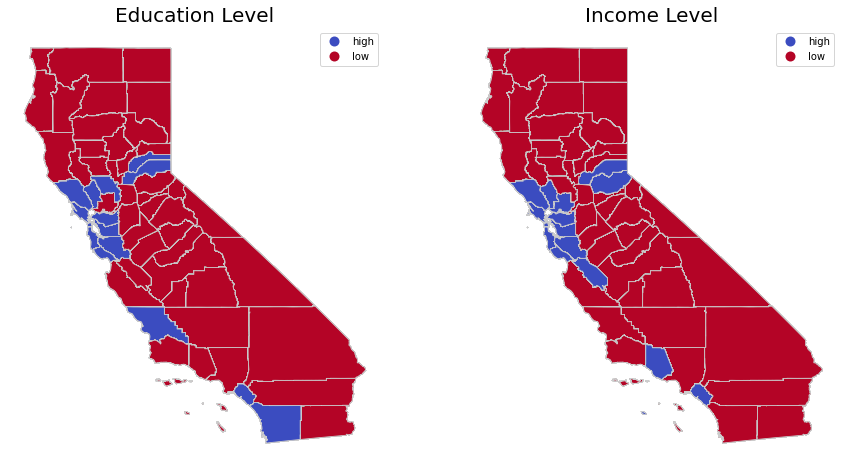

In [18]:
# Education
fig, ax = plt.subplots(ncols=2,figsize=(15,8))
merged_still.plot(column='education_level', cmap='coolwarm', linewidth=0.8, ax=ax[0], edgecolor='0.8',legend=True)
ax[0].axis('off')
ax[0].set_title('Education Level', fontdict={'fontsize':'20', 'fontweight':'3'})

# Income
merged_still.plot(column='income_level', cmap='coolwarm', linewidth=0.8, ax=ax[1], edgecolor='0.8',legend=True)
ax[1].axis('off')
ax[1].set_title('Income Level', fontdict={'fontsize':'20','fontweight':'3'})
plt.show()

By normalizing the colors, we created a pair of still maps give a time-lapse effect. The map on the left shows that not even 10% of a single county’s population was vaccinated on Feb 3rd. The map on the right shows that about 30% of some counties’ populations were vaccinated on April 30th. Fortunately, this means that more people are getting vaccinated. High income and high education counties tend to have a higher proportion of their population vaccinated. This is in support of the inference that high income causes higher proportion of vaccination.

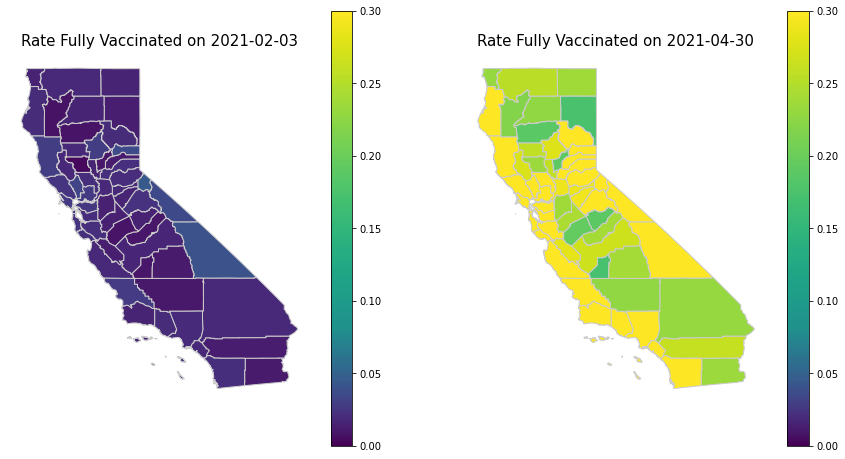

In [19]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

column = '% fully vaccinated'
cmap = 'viridis'

date_1 = merged_still['administered_date'][50] # Adjust date 1 here
date_2 = merged_still['administered_date'][len(merged_still)-3] # Adjust date 2 here

merged_on_date_1 = merged_still[merged_still['administered_date'] == date_1]
merged_on_date_2 = merged_still[merged_still['administered_date'] == date_2]

fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

# set up the normalization
max_of_column = merged_still[column].max()
normalize = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.08,vmax=0.3)

# setup the colorbar
cbar = cm.ScalarMappable(norm=normalize, cmap=cmap)
plt.colorbar(cbar,ax=ax[0])
plt.colorbar(cbar,ax=ax[1])

# Date 1
plot_1 = merged_on_date_1.plot(column=column, cmap=cmap, ax=ax[0], edgecolor='0.8',legend=False,norm=normalize)
ax[0].axis('off')
ax[0].set_title('Rate Fully Vaccinated on {}'.format(date_1), fontdict={'fontsize': '15', 'fontweight':'3'})

# Date 2
merged_on_date_2.plot(column=column, cmap=cmap, ax=ax[1], edgecolor='0.8',legend=False,norm=normalize)
ax[1].axis('off')
ax[1].set_title('Rate Fully Vaccinated on {}'.format(date_2), fontdict={'fontsize': '15', 'fontweight':'3'})

plt.show()

## Question 2

### Line Graphs: Number of Fully Vaccinated People in Each Demographic Category Over Time

The following cells output 3 line graphs, one for each demographic category. Each demographic category is plotted against the same time, which is 15 December 2020 through 3 May 2021.

Text(0.5, 0, 'Date')

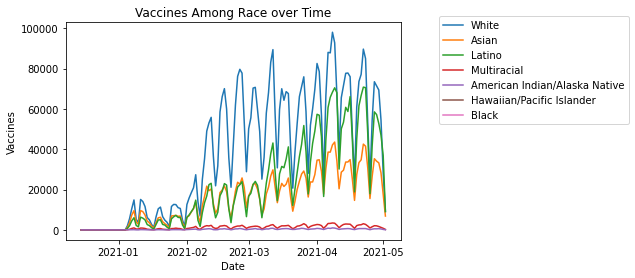

In [20]:
dem_vax_filtered = dem_vax[(dem_vax["demographic_value"] != 'Other Race') & (dem_vax["demographic_value"] != 'Unknown/undifferentiated') & (dem_vax["demographic_value"] != 'Unknown') & (dem_vax["demographic_value"] != 'Unknown Agegroup')]
race = dem_vax_filtered[dem_vax_filtered["demographic_category"] == "Race/Ethnicity"]
plt.plot(race[race["demographic_value"] == "White"]['administered_date'], race[race["demographic_value"] == "White"]['fully_vaccinated'])
plt.plot(race[race["demographic_value"] == "Asian"]['administered_date'], race[race["demographic_value"] == "Asian"]['fully_vaccinated'])
plt.plot(race[race["demographic_value"] == "Latino"]['administered_date'], race[race["demographic_value"] == "Latino"]['fully_vaccinated'])
plt.plot(race[race["demographic_value"] == "Multiracial"]['administered_date'], race[race["demographic_value"] == "Multiracial"]['fully_vaccinated'])
plt.plot(race[race["demographic_value"] == "American Indian or Alaska Native"]['administered_date'], race[race["demographic_value"] == "American Indian or Alaska Native"]['fully_vaccinated'])
plt.plot(race[race["demographic_value"] == "Hawaiian/Pacific Islander"]['administered_date'], race[race["demographic_value"] == "Hawaiian/Pacific Islander"]['fully_vaccinated'])
plt.plot(race[race["demographic_value"] == "Black"]['administered_date'], race[race["demographic_value"] == "Black"]['fully_vaccinated'])
plt.legend(['White', 'Asian', 'Latino', 'Multiracial', 'American Indian/Alaska Native', 'Hawaiian/Pacific Islander', 'Black'], bbox_to_anchor=(1.1, 1.05))
plt.title("Vaccines Among Race over Time")
plt.ylabel("Vaccines")
plt.xlabel("Date")


Text(0.5, 0, 'Date')

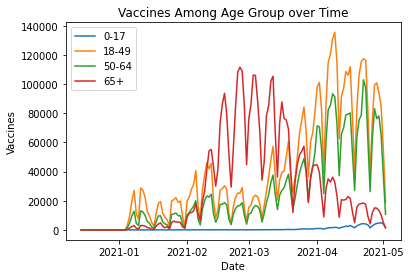

In [21]:
age = dem_vax_filtered[dem_vax_filtered["demographic_category"] == "Age Group"]
plt.plot(age[age["demographic_value"] == "0-17"]['administered_date'], age[age["demographic_value"] == "0-17"]['fully_vaccinated'])
plt.plot(age[age["demographic_value"] == "18-49"]['administered_date'], age[age["demographic_value"] == "18-49"]['fully_vaccinated'])
plt.plot(age[age["demographic_value"] == "50-64"]['administered_date'], age[age["demographic_value"] == "50-64"]['fully_vaccinated'])
plt.plot(age[age["demographic_value"] == "65+"]['administered_date'], age[age["demographic_value"] == "65+"]['fully_vaccinated'])
plt.legend(["0-17", '18-49', '50-64', '65+'])
plt.title("Vaccines Among Age Group over Time")
plt.ylabel("Vaccines")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

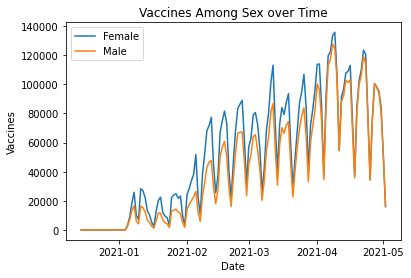

In [22]:
sex = dem_vax_filtered[dem_vax_filtered["demographic_category"] == "Gender"]
plt.plot(sex[sex["demographic_value"] == "Female"]['administered_date'], sex[sex["demographic_value"] == "Female"]['fully_vaccinated'])
plt.plot(sex[sex["demographic_value"] == "Male"]['administered_date'], sex[sex["demographic_value"] == "Male"]['fully_vaccinated'])
plt.legend(['Female', 'Male'])
plt.title("Vaccines Among Sex over Time")
plt.ylabel("Vaccines")
plt.xlabel("Date")

### Bar Chart: Vaccine Rate Among Age Group

Following the same idea of visualizing the differences in vaccine rates among varying demographic groups, the following bar chart plots the vaccination rate (total amount of people fully vaccinated / total population) per each age group. As we can expect as per the CDC's Vaccine Rollout guidelines, older groups have much higher vaccination rates.

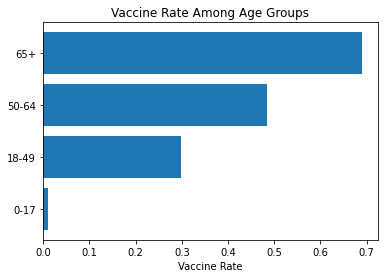

In [23]:
pop_dem = pd.read_csv("/work/ca_pop_sex_age.csv")

first = pop_dem.iloc[19]["Total"]
second = pop_dem.iloc[23]["Total"] - (pop_dem.iloc[11]["Total"] + pop_dem.iloc[12]["Total"] + pop_dem.iloc[13]["Total"]) 
third = pop_dem.iloc[11]["Total"] + pop_dem.iloc[12]["Total"] + pop_dem.iloc[13]["Total"]
fourth = pop_dem.iloc[27]["Total"]

ca_pop = 39512223

dem_vax_grouped = dem_vax.groupby(["demographic_value"], as_index=False).sum()
first_age_rate = dem_vax_grouped["fully_vaccinated"][0]/first
second_age_rate = dem_vax_grouped["fully_vaccinated"][1]/second
third_age_rate = dem_vax_grouped["fully_vaccinated"][2]/third
fourth_age_rate = dem_vax_grouped["fully_vaccinated"][3]/fourth

plt.barh(["0-17", "18-49", "50-64", "65+"], [first_age_rate, second_age_rate, third_age_rate, fourth_age_rate])
plt.title("Vaccine Rate Among Age Groups")
plt.xlabel("Vaccine Rate")
plt.show()

### Bar Chart: Number of Vaccines Per Age Group, Conditioned on Vaccine Rollout Phase

Since a large part of vaccine accessibility was age, we wanted to account for its factor in specific phases. Conditioning on Vaccine Rollout Phase ensured we could take a closer look at discrepancies in implicit vaccination accessibility, regardless of who was explicitly given access. As we can expect, trends of age groups follow the general expectations given the respective Vaccine Rollout Phase.

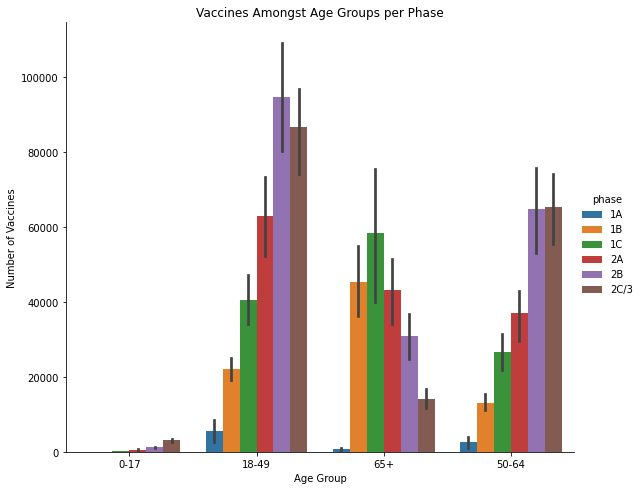

In [24]:
sns.catplot(x="demographic_value", y="fully_vaccinated", hue="phase", kind="bar", height=6.5, aspect=8/6.5, data=dem_vax[(dem_vax["demographic_category"] == "Age Group") & (dem_vax["demographic_value"] != "Unknown Agegroup")].sort_values("administered_date"))
plt.xlabel("Age Group")
plt.ylabel("Number of Vaccines")
plt.title("Vaccines Amongst Age Groups per Phase")
plt.show()

### Bar Chart: Vaccine Rates Among Racial Groups

Similarly to age, the following bar chart plots the vaccination rate (total amount of people fully vaccinated / total population) per each racial/ethnicity group. We sorted the results by vaccination rate to more clearly show the racial distribution of vaccine rates.

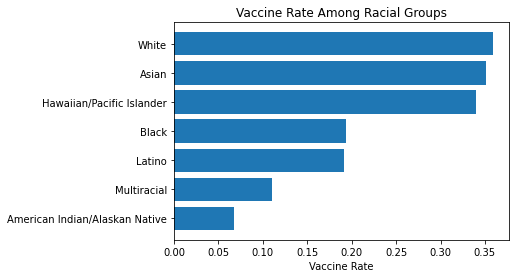

In [25]:
ai_an_rate = dem_vax_grouped["fully_vaccinated"][4]/(.016*ca_pop)
asian_rate = dem_vax_grouped["fully_vaccinated"][5]/(.155*ca_pop)
black_rate = dem_vax_grouped["fully_vaccinated"][6]/(.065*ca_pop)
latino_rate = dem_vax_grouped["fully_vaccinated"][8]/(.394*ca_pop)
multiracial_rate = dem_vax_grouped["fully_vaccinated"][10]/(.04*ca_pop)
hawaiian_pi_rate = dem_vax_grouped["fully_vaccinated"][11]/(.005*ca_pop)
white_rate = dem_vax_grouped["fully_vaccinated"][16]/(.365*ca_pop)
plt.barh(["American Indian/Alaskan Native", "Multiracial", "Latino", "Black", "Hawaiian/Pacific Islander", "Asian", "White"], [ai_an_rate, multiracial_rate, latino_rate, black_rate, hawaiian_pi_rate, asian_rate, white_rate])
plt.title("Vaccine Rate Among Racial Groups")
plt.xlabel("Vaccine Rate")
plt.show()

### Bar Chart: Number of Vaccines Per Race, Conditioned on Vaccine Rollout Phase

In the following plot, we condition on Vaccine Rollout Phase to see if there were any further racial discrepancies in vaccine rates per different phases. Conditioning by phase allows us to see if certain racial groups increased or decreased their vaccination rate over time, perhaps due to changes in accessibility or cultural perception of the vaccine.

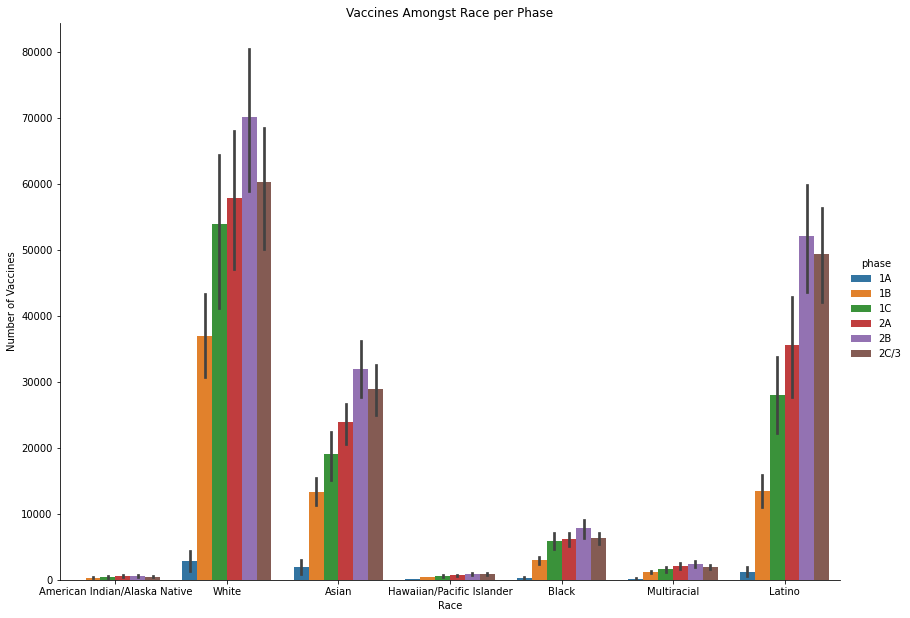

In [26]:
dem_vax2 = dem_vax.copy()
dem_vax2['demographic_value'] = dem_vax2['demographic_value'].str.replace('Black or African American','Black')
dem_vax2['demographic_value'] = dem_vax2['demographic_value'].str.replace('Native Hawaiian or Other Pacific Islander','Hawaiian/Pacific Islander')
dem_vax2['demographic_value'] = dem_vax2['demographic_value'].str.replace('American Indian or Alaska Native','American Indian/Alaska Native')
dem_vax_race = dem_vax2[(dem_vax2["demographic_category"] == "Race/Ethnicity") & (dem_vax2["demographic_value"] != 'Other Race') & (dem_vax2["demographic_value"] != 'Unknown')].sort_values("administered_date")
sns.catplot(x="demographic_value", y="fully_vaccinated", hue="phase", kind="bar", height=8.27, aspect=11.7/8.27, legend_out=True, data=dem_vax_race)
plt.xlabel("Race")
plt.ylabel("Number of Vaccines")
plt.title("Vaccines Amongst Race per Phase")
plt.show()

### Bar Chart: Vaccine Rates Among Sex

As before, we stratify by sex to see differences in vaccination rate among men and women.

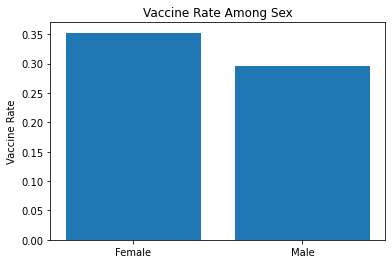

In [27]:
female = dem_vax_grouped[dem_vax_grouped["demographic_value"] == "Female"]
male = dem_vax_grouped[dem_vax_grouped["demographic_value"] == "Male"]

female_rate = female["fully_vaccinated"].values[0]/(.503*ca_pop)
male_rate = male["fully_vaccinated"].values[0]/(.497*ca_pop)

plt.bar(["Female", "Male"], [female_rate, male_rate])
plt.title("Vaccine Rate Among Sex")
plt.ylabel("Vaccine Rate")
plt.show()

### Bar Chart: Number of Vaccines Per Sex, Conditioned on Vaccine Rollout Phase

Here we condition by phase to more closely see any discrepancies between sex in vaccination rates during the Vaccine Rollout timeline.

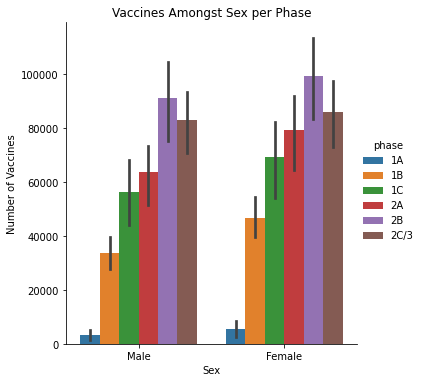

In [28]:
sns.catplot(x="demographic_value", y="fully_vaccinated", hue="phase", kind="bar", data=dem_vax[(dem_vax["demographic_category"] == "Gender") & (dem_vax["demographic_value"]!= "Unknown/undifferentiated")].sort_values("administered_date"))
plt.xlabel("Sex")
plt.ylabel("Number of Vaccines")
plt.title("Vaccines Amongst Sex per Phase")
plt.show()

### Bar Chart: Example of Weekly Fluctuation in Vaccine Rates

By looking at previous graphs of vaccination rates over time, we saw regular dips that seemed to be occurring every week. Investigating further in the data, we take a look at an example week which shows a daily trend which seems to follow the general availability of individuals as per the weekday work schedule. 

As we can see, individuals get vaccinated most frequently on Friday (when the average person is most available) and least frequently on Sunday (when the average person is least available). In order of lowest to highest vaccine rate: Sunday, Monday, Tuesday, Saturday, Wednesday, Thursday, Friday. We also ensured to compare this week to the rest of the data, and the trend follows, regardless of demographic group.

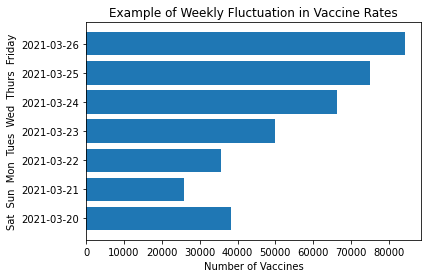

In [29]:
march_week = dem_vax[dem_vax["demographic_value"]=="18-49"].sort_values("administered_date", ascending=False)[37:44]
plt.barh('administered_date', "fully_vaccinated", data=march_week)

plt.title("Example of Weekly Fluctuation in Vaccine Rates")
plt.ylabel("Sat  Sun  Mon  Tues  Wed  Thurs  Friday")
plt.xlabel("Number of Vaccines")
plt.show()

### Bar Chart: Percentage of Each Age Group

To see if any groups are over or underrepresented, we took the number of fully vaccinated people in each age group by 3 May 2021, divided it by the total, converted it to a percent, and plotted that on a bar chart.

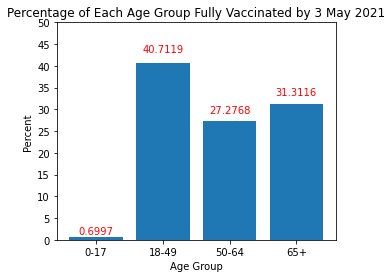

In [30]:
ages_rows = dem_vax_grouped[:4]
ages = ages_rows['demographic_value'].unique()
total = ages_rows['fully_vaccinated'].sum()
percents = []
for age in ages_rows['fully_vaccinated'].values:
    percent = (age/total)*100
    percents.append(percent)
fig, ax = plt.subplots(figsize=(5,4))
rects = plt.bar(ages,percents)
plt.title("Percentage of Each Age Group Fully Vaccinated by 3 May 2021")
plt.xlabel("Age Group")
plt.ylabel("Percent")
plt.yticks(np.arange(0,51,5))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                round(height,4),
                ha='center', va='bottom',color='red')

autolabel(rects)

plt.show()

# Question 1: Causal Inference

**Does a higher median household county income level cause a higher proportion of COVID-19 vaccination?**
___

## Independent T-test

The code in the following cell helps set up the data for the independent t-test. We could isolate the dates to those in which every county is accounted for within a certain timeframe, but in this case, we decided to use the entire timeframe of the dataset.

In [31]:
isolate_dates = dates #[:90] 15 Dec 2020 - 12 March 2021
all_counties_accounted_for_that_day = []
ttest_dates = []
days = 0
for date in isolate_dates:
    day = county_vax[county_vax['administered_date'] == date]
    num_counties = len(day)
    all_counties_accounted_for_that_day.append(num_counties == 58)
    days += 1
    if num_counties == 58:
        ttest_dates.append(date)
print('All counties were accounted for in {} out of the {} days.'.format(sum(all_counties_accounted_for_that_day),days))

All counties were accounted for in 64 out of the 139 days.


After creating a new DataFrame by isolating the county_vax DataFrame for the desired dates, create a column representing the percentage of fully vaccinated people in that county. Then, create a column indicating which vaccine rollout phase the date falls under.

In [32]:
boolean_list = county_vax.administered_date.isin(ttest_dates) 
ttest_df = county_vax[boolean_list] # df with the dates we want
ttest_df = ttest_df.merge(county_pop, on='county') # add the population col
ttest_df['% fully vaccinated'] = ttest_df['cumulative_fully_vaccinated']/ttest_df['population'].str.replace(',','').astype(int) # add the rate col

ttest_phases = []
for i in pd.to_datetime(ttest_df["administered_date"]):
    if i < pd.to_datetime("01-18-2021"):
        ttest_phases.append("1A")
    elif (i >= pd.to_datetime("01-18-2021") and i < pd.to_datetime("03-15-2021")):
        ttest_phases.append("1B")
    elif (i >= pd.to_datetime("03-15-2021") and i < pd.to_datetime("03-23-2021")):
        ttest_phases.append("1C")
    elif (i >= pd.to_datetime("03-23-2021") and i < pd.to_datetime("03-30-2021")):
        ttest_phases.append("2A")
    elif (i >= pd.to_datetime("03-30-2021") and i < pd.to_datetime("04-12-2021")):
        ttest_phases.append("2B")
    elif i >= pd.to_datetime("04-12-2021") :
        ttest_phases.append("2C/3")
ttest_df["phase"] = ttest_phases
ttest_df

county administered_date  fully_vaccinated  \
0     Alameda        2020-12-21                 0   
1     Alameda        2020-12-30                 0   
2     Alameda        2021-01-05               233   
3     Alameda        2021-01-06               814   
4     Alameda        2021-01-08              1620   
...       ...               ...               ...   
3707     Yuba        2021-04-24                93   
3708     Yuba        2021-04-27               219   
3709     Yuba        2021-04-28               275   
3710     Yuba        2021-04-29               239   
3711     Yuba        2021-04-30               144   

      cumulative_fully_vaccinated education_level income_level  pfizer_doses  \
0                               1            high         high          1860   
1                               1            high         high          1361   
2                             250            high         high          1265   
3                            1064            high         high          1780   
4                            3762            high         high          2698   
...                           ...             ...          ...           ...   
3707                        13811             low          low            68   
3708                        14182             low          low           149   
3709                        14457             low          low           168   
3710                        14696             low          low            25   
3711                        14840             low          low            48   

      moderna_doses  jj_doses population  % fully vaccinated phase  
0                 2         0  1,662,730        6.014206e-07    1A  
1              1763         0  1,662,730        6.014206e-07    1A  
2               940         0  1,662,730        1.503551e-04    1A  
3              1467         0  1,662,730        6.399115e-04    1A  
4              2028         0  1,662,730        2.262544e-03    1A  
...             ...       ...        ...                 ...   ...  
3707            148         0     77,426        1.783768e-01  2C/3  
3708            276        10     77,426        1.831684e-01  2C/3  
3709            242         5     77,426        1.867202e-01  2C/3  
3710            316         2     77,426        1.898070e-01  2C/3  
3711            165        28     77,426        1.916669e-01  2C/3  

[3712 rows x 12 columns]

Create an empty dictionary where the key is the county name and the value is an empty list, which will have as many elements as desired dates. By isolating the data by phase and county name, calculate the mean percent fully vaccinated within the county within the phase and append it to the dictionary. Create a new DataFrame, where the first six columns represent the average vaccination rate for each vaccine rollout phase and the last two represent the county names and the treatment variable. Each row corresponds to one county.

In [33]:
county_names = ttest_df['county'].unique()
phases = ttest_df['phase'].unique()
ttest_dict = {county: [] for county in county_names}

for phase in phases:
    one_phase = ttest_df[ttest_df['phase'] == phase]
    for name in county_names:
        one_county = one_phase[one_phase['county'] == name]
        ave_rate = np.mean(one_county['% fully vaccinated'])
        ttest_dict[name].append(ave_rate)

ave_rates_df = pd.DataFrame.from_dict(ttest_dict, orient='index',columns=['1A','1B','1C','2A','2B','2C/3'])
ave_rates_df['county'] = county_names
ave_rates_df['income_level'] = ave_rates_df['county'].map(income_dict)
ave_rates_df

1A        1B        1C        2A        2B      2C/3  \
Alameda          0.002909  0.055402  0.151041  0.200193  0.260843  0.344508   
Alpine           0.002156  0.133279  0.227293  0.255732  0.359536  0.516274   
Amador           0.001890  0.044350  0.120622  0.156733  0.203219  0.260773   
Butte            0.003515  0.069347  0.148857  0.162684  0.194764  0.256778   
Calaveras        0.001842  0.050113  0.138388  0.165401  0.215972  0.260908   
Colusa           0.000374  0.026195  0.091386  0.116487  0.152760  0.211480   
Contra Costa     0.003752  0.069720  0.167929  0.208991  0.256621  0.361854   
Del Norte        0.001110  0.037932  0.086746  0.118011  0.156247  0.209762   
El Dorado        0.002759  0.059953  0.142120  0.169460  0.214981  0.280752   
Fresno           0.001777  0.042362  0.093683  0.125589  0.178785  0.246526   
Glenn            0.001264  0.048096  0.127039  0.147357  0.178667  0.234242   
Humboldt         0.003139  0.061754  0.148847  0.177833  0.216103  0.270343   
Imperial         0.001220  0.030510  0.081259  0.117572  0.160906  0.215125   
Inyo             0.008692  0.076937  0.189450  0.207146  0.238728  0.300007   
Kern             0.000993  0.034698  0.084816  0.110516  0.143823  0.202410   
Kings            0.001366  0.022617  0.056166  0.076674  0.108175  0.160604   
Lake             0.001697  0.054577  0.148524  0.173662  0.203313  0.256865   
Lassen           0.000743  0.038470  0.077857  0.088307  0.109463  0.165115   
Los Angeles      0.003302  0.054120  0.121977  0.149353  0.195463  0.277320   
Madera           0.000953  0.034527  0.092962  0.124460  0.162537  0.220745   
Marin            0.003780  0.081018  0.201458  0.266783  0.340151  0.455817   
Mariposa         0.004797  0.027986  0.074886  0.112866  0.135022  0.177081   
Mendocino        0.001860  0.080974  0.191004  0.246141  0.298082  0.332752   
Merced           0.000951  0.028023  0.069388  0.093945  0.130531  0.179206   
Modoc            0.004591  0.073542  0.166807  0.180747  0.205409  0.229022   
Mono             0.003399  0.163453  0.293104  0.298311  0.376489  0.461370   
Monterey         0.003186  0.040038  0.101615  0.126515  0.173969  0.268807   
Napa             0.004810  0.094506  0.191463  0.232182  0.293364  0.378407   
Nevada           0.002046  0.050136  0.139885  0.168723  0.209468  0.275059   
Orange           0.003271  0.058864  0.139777  0.156472  0.196640  0.292371   
Placer           0.003443  0.075086  0.168539  0.196367  0.238367  0.310401   
Plumas           0.003678  0.047382  0.121458  0.161640  0.218831  0.299793   
Riverside        0.001781  0.042891  0.117291  0.139597  0.168170  0.230070   
Sacramento       0.002922  0.049049  0.119997  0.146341  0.189223  0.263961   
San Benito       0.001818  0.035144  0.089242  0.119049  0.171007  0.255597   
San Bernardino   0.002884  0.042490  0.101580  0.120447  0.146575  0.204077   
San Diego        0.002953  0.067151  0.168109  0.195359  0.227944  0.302568   
San Francisco    0.003021  0.062694  0.155673  0.202062  0.278172  0.381812   
San Joaquin      0.002193  0.036373  0.089042  0.116247  0.153284  0.216842   
San Luis Obispo  0.003104  0.063581  0.148660  0.176871  0.215262  0.300752   
San Mateo        0.003234  0.066179  0.167549  0.214576  0.271834  0.363555   
Santa Barbara    0.002080  0.052768  0.118094  0.143600  0.190401  0.285728   
Santa Clara      0.003326  0.056988  0.138064  0.170770  0.215101  0.304792   
Santa Cruz       0.004401  0.066488  0.165963  0.198798  0.246219  0.330548   
Shasta           0.002803  0.050580  0.123114  0.135539  0.152893  0.203806   
Sierra           0.002197  0.093794  0.232541  0.265466  0.305166  0.374072   
Siskiyou         0.003555  0.057707  0.137736  0.151027  0.191119  0.242614   
Solano           0.003891  0.057471  0.129291  0.163110  0.208126  0.283594   
Sonoma           0.003427  0.067876  0.186264  0.224761  0.271246  0.363273   
Stanislaus       0.002049  0.040103  0.090792  0.115940  0.153725  0.2177

### Check Normality Assumption

Use this new DataFrame of average vaccination rates to check for the normality assumption of an independent t-test. Histograms and qqplots are useful and graphical ways to check if the data is normally distributed. The following histograms show the distribution of average vaccine rate per phase, conditioned on income. The curves are roughly bell-shaped, which supports the assumption that the data is normally distributed.

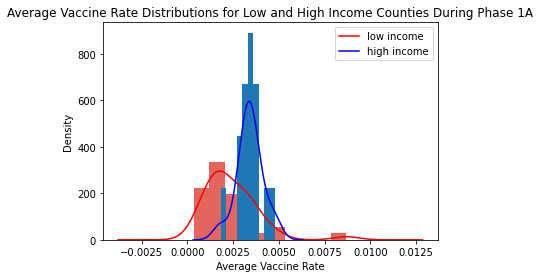

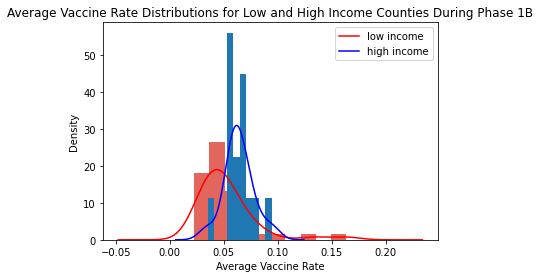

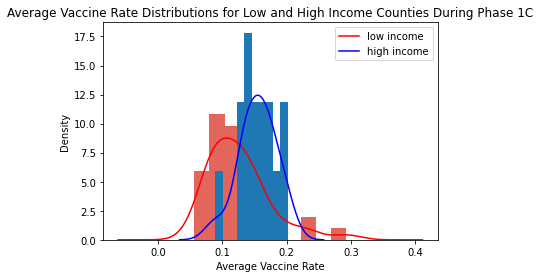

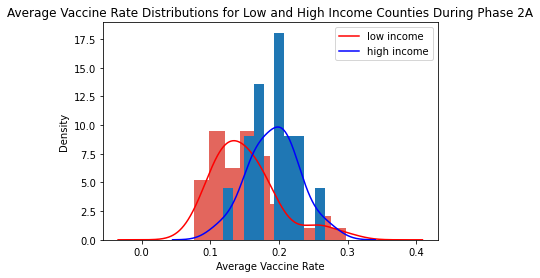

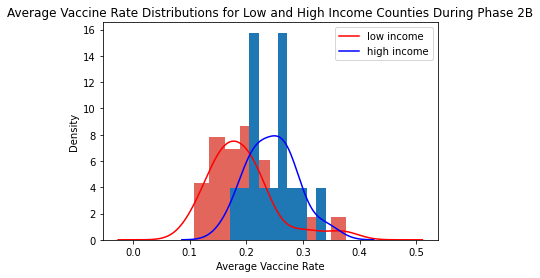

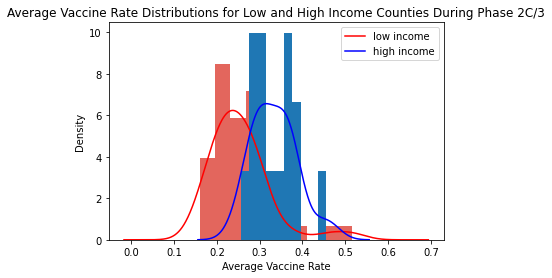

In [34]:
# Histograms
low = ave_rates_df[ave_rates_df['income_level'] == 'low']
high = ave_rates_df[ave_rates_df['income_level'] == 'high']

for phase in ave_rates_df.columns[:6]:
    fig, ax = plt.subplots()
    low[phase].plot.hist(density=True, label='low income',legend=True,color='#e3665d')
    high[phase].plot.hist(density=True, label='high income',legend=True)
    low[phase].plot.kde(ax=ax,legend=False, color='red')
    high[phase].plot.kde(ax=ax,legend=False, color='blue')
    plt.title("Average Vaccine Rate Distributions for Low and High Income Counties During Phase {}".format(phase))
    plt.xlabel("Average Vaccine Rate")
    plt.show()

As for the qqplots, the data is sorted smallest to largest on the x-axis. The y-axis has the expected numbers if the data was normally distributed. 

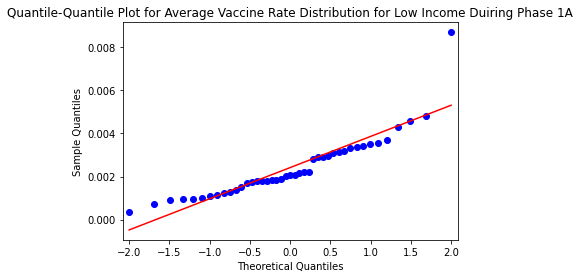

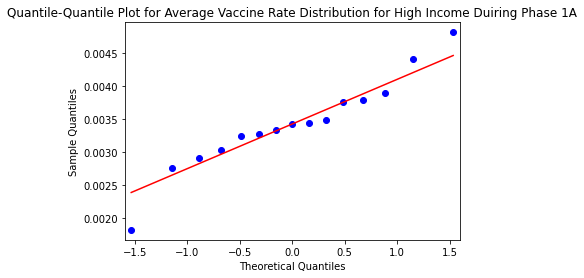

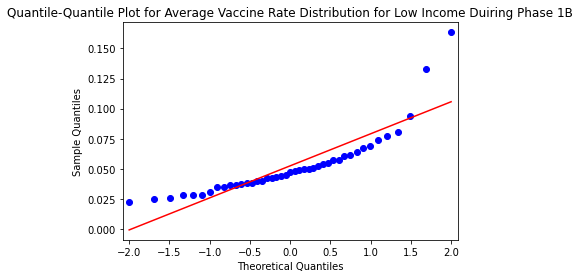

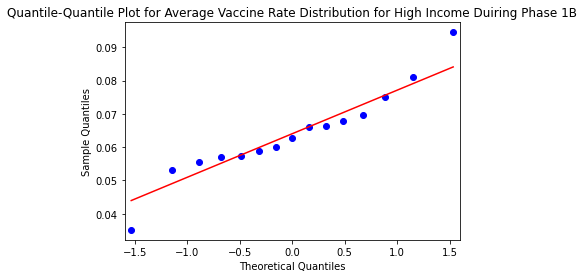

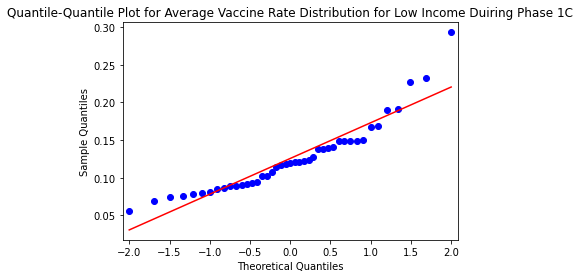

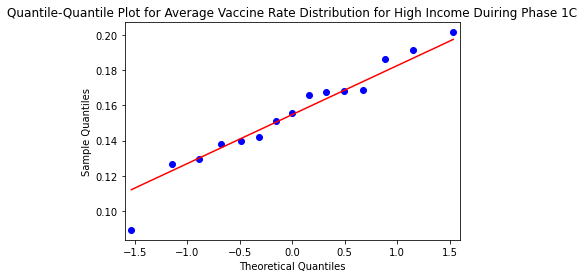

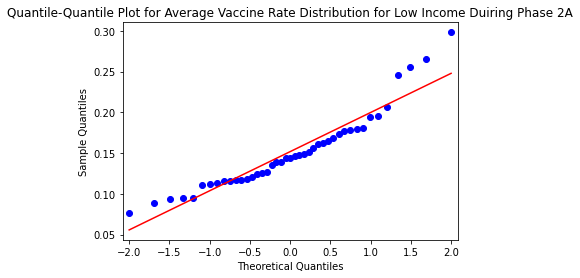

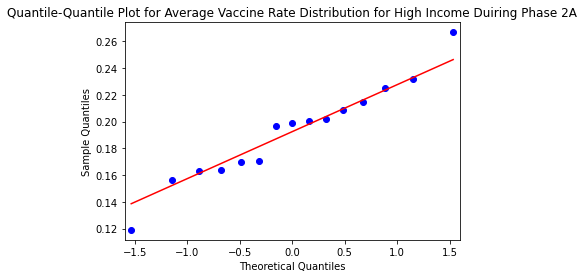

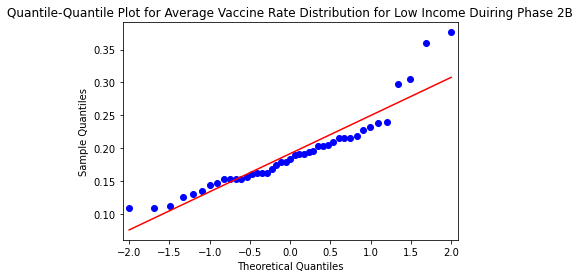

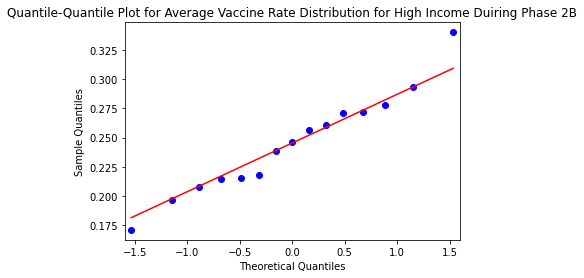

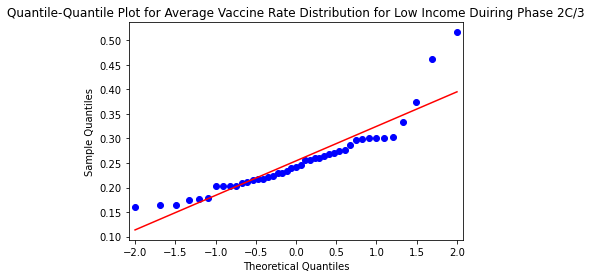

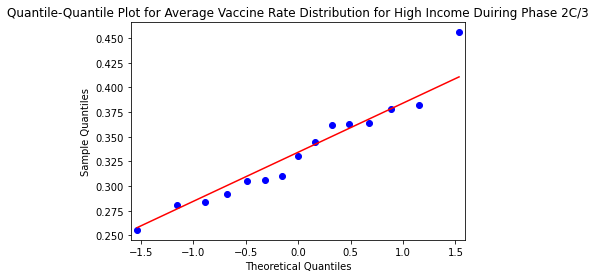

In [35]:
# Check normality assumption

# Quantile-Quantile Plots
for phase in ave_rates_df.columns[:6]:
    qqplot(low[phase],line='s')
    plt.title('Quantile-Quantile Plot for Average Vaccine Rate Distribution for Low Income Duiring Phase {}'.format(phase))
    plt.show()

    qqplot(high[phase],line='s')
    plt.title('Quantile-Quantile Plot for Average Vaccine Rate Distribution for High Income Duiring Phase {}'.format(phase))
    plt.show()

Seeing that the blue lines straddle the red line somewhat closely, it is safe to assume that the data satisfies the normality assumption for an independent t-test, which we may now carry out. Output the results by running the following cells.

### T-test Results

Output the results by running the following cell.

In [36]:
for phase in ave_rates_df.columns[:6]:
    statistic = stats.ttest_ind(low[phase], high[phase], equal_var=False)[0]
    pval = stats.ttest_ind(low[phase], high[phase], equal_var=False)[1]
    print('Results of t-test for Phase {}: statistic= {}, p-val= {}'.format(phase,round(statistic,4),round(pval,4))) # Welch's t-test because unequal variance
    print()

Results of t-test for Phase 1A: statistic= -3.5066, p-val= 0.001

Results of t-test for Phase 1B: statistic= -2.139, p-val= 0.0375

Results of t-test for Phase 1C: statistic= -2.801, p-val= 0.0077

Results of t-test for Phase 2A: statistic= -3.4019, p-val= 0.0018

Results of t-test for Phase 2B: statistic= -3.7644, p-val= 0.0006

Results of t-test for Phase 2C/3: statistic= -4.6563, p-val= 0.0



## IPW

Prepare the DataFrame to calculate the average treatment effect between income (treatment) and vaccination rate (outcome). First, append a column of 0's and 1's for each phase by splitting the average vaccination rate below and above the median, respectively, for each phase. Then, append a column of 0's and 1's for income and education (confounder) using the low and high levels, respectively. 

In [37]:
ipw_df = ave_rates_df.copy()
ipw_df['education_level'] = ipw_df['county'].map(education_dict)  # create education col
for phase in ipw_df.columns[:6]:
    ipw_df[phase + ' rate level'] = (ipw_df[phase] >= ipw_df[phase].median())*1  # define high rate and low rate
    
income_dummies = pd.get_dummies(ipw_df['income_level'])[['high']].rename(columns={'high':'income level'})                
education_dummies = pd.get_dummies(ipw_df['education_level'])[['high']].rename(columns={'high':'education level'})             
ipw_df = pd.concat([ipw_df, income_dummies,education_dummies],axis=1)
ipw_df['income'] = income['Income'].values           
ipw_df['education'] = education['% college graduates'].values 
ipw_df
#    'income level' = 1/0,    'income_level' = high/low,    'income' = numeric 
# 'education level' = 1/0, 'education_level' = high/low, 'education' = numeric

1A        1B        1C        2A        2B      2C/3  \
Alameda          0.002909  0.055402  0.151041  0.200193  0.260843  0.344508   
Alpine           0.002156  0.133279  0.227293  0.255732  0.359536  0.516274   
Amador           0.001890  0.044350  0.120622  0.156733  0.203219  0.260773   
Butte            0.003515  0.069347  0.148857  0.162684  0.194764  0.256778   
Calaveras        0.001842  0.050113  0.138388  0.165401  0.215972  0.260908   
Colusa           0.000374  0.026195  0.091386  0.116487  0.152760  0.211480   
Contra Costa     0.003752  0.069720  0.167929  0.208991  0.256621  0.361854   
Del Norte        0.001110  0.037932  0.086746  0.118011  0.156247  0.209762   
El Dorado        0.002759  0.059953  0.142120  0.169460  0.214981  0.280752   
Fresno           0.001777  0.042362  0.093683  0.125589  0.178785  0.246526   
Glenn            0.001264  0.048096  0.127039  0.147357  0.178667  0.234242   
Humboldt         0.003139  0.061754  0.148847  0.177833  0.216103  0.270343   
Imperial         0.001220  0.030510  0.081259  0.117572  0.160906  0.215125   
Inyo             0.008692  0.076937  0.189450  0.207146  0.238728  0.300007   
Kern             0.000993  0.034698  0.084816  0.110516  0.143823  0.202410   
Kings            0.001366  0.022617  0.056166  0.076674  0.108175  0.160604   
Lake             0.001697  0.054577  0.148524  0.173662  0.203313  0.256865   
Lassen           0.000743  0.038470  0.077857  0.088307  0.109463  0.165115   
Los Angeles      0.003302  0.054120  0.121977  0.149353  0.195463  0.277320   
Madera           0.000953  0.034527  0.092962  0.124460  0.162537  0.220745   
Marin            0.003780  0.081018  0.201458  0.266783  0.340151  0.455817   
Mariposa         0.004797  0.027986  0.074886  0.112866  0.135022  0.177081   
Mendocino        0.001860  0.080974  0.191004  0.246141  0.298082  0.332752   
Merced           0.000951  0.028023  0.069388  0.093945  0.130531  0.179206   
Modoc            0.004591  0.073542  0.166807  0.180747  0.205409  0.229022   
Mono             0.003399  0.163453  0.293104  0.298311  0.376489  0.461370   
Monterey         0.003186  0.040038  0.101615  0.126515  0.173969  0.268807   
Napa             0.004810  0.094506  0.191463  0.232182  0.293364  0.378407   
Nevada           0.002046  0.050136  0.139885  0.168723  0.209468  0.275059   
Orange           0.003271  0.058864  0.139777  0.156472  0.196640  0.292371   
Placer           0.003443  0.075086  0.168539  0.196367  0.238367  0.310401   
Plumas           0.003678  0.047382  0.121458  0.161640  0.218831  0.299793   
Riverside        0.001781  0.042891  0.117291  0.139597  0.168170  0.230070   
Sacramento       0.002922  0.049049  0.119997  0.146341  0.189223  0.263961   
San Benito       0.001818  0.035144  0.089242  0.119049  0.171007  0.255597   
San Bernardino   0.002884  0.042490  0.101580  0.120447  0.146575  0.204077   
San Diego        0.002953  0.067151  0.168109  0.195359  0.227944  0.302568   
San Francisco    0.003021  0.062694  0.155673  0.202062  0.278172  0.381812   
San Joaquin      0.002193  0.036373  0.089042  0.116247  0.153284  0.216842   
San Luis Obispo  0.003104  0.063581  0.148660  0.176871  0.215262  0.300752   
San Mateo        0.003234  0.066179  0.167549  0.214576  0.271834  0.363555   
Santa Barbara    0.002080  0.052768  0.118094  0.143600  0.190401  0.285728   
Santa Clara      0.003326  0.056988  0.138064  0.170770  0.215101  0.304792   
Santa Cruz       0.004401  0.066488  0.165963  0.198798  0.246219  0.330548   
Shasta           0.002803  0.050580  0.123114  0.135539  0.152893  0.203806   
Sierra           0.002197  0.093794  0.232541  0.265466  0.305166  0.374072   
Siskiyou         0.003555  0.057707  0.137736  0.151027  0.191119  0.242614   
Solano           0.003891  0.057471  0.129291  0.163110  0.208126  0.283594   
Sonoma           0.003427  0.067876  0.186264  0.224761  0.271246  0.363273   
Stanislaus       0.002049  0.040103  0.090792  0.115940  0.153725  0.2177

Do the same thing, but average across the entire timeframe of the dataset and not each phase. 

In [38]:
county_names = ttest_df['county'].unique()
ttest_dict = {county: [] for county in county_names}

for name in county_names:
    one_county = ttest_df[ttest_df['county'] == name]
    ave_rate = np.mean(one_county['% fully vaccinated'])
    ttest_dict[name].append(ave_rate)

ave_rates_df2 = pd.DataFrame.from_dict(ttest_dict, orient='index',columns=['all phases'])
ave_rates_df2['all phases rate level'] = (ave_rates_df2['all phases'] >= ave_rates_df2['all phases'].median())*1  # define high rate and low rate           
ipw_df[['all phases rate level','all phases']] = ave_rates_df2[['all phases rate level','all phases']]
ipw_df

1A        1B        1C        2A        2B      2C/3  \
Alameda          0.002909  0.055402  0.151041  0.200193  0.260843  0.344508   
Alpine           0.002156  0.133279  0.227293  0.255732  0.359536  0.516274   
Amador           0.001890  0.044350  0.120622  0.156733  0.203219  0.260773   
Butte            0.003515  0.069347  0.148857  0.162684  0.194764  0.256778   
Calaveras        0.001842  0.050113  0.138388  0.165401  0.215972  0.260908   
Colusa           0.000374  0.026195  0.091386  0.116487  0.152760  0.211480   
Contra Costa     0.003752  0.069720  0.167929  0.208991  0.256621  0.361854   
Del Norte        0.001110  0.037932  0.086746  0.118011  0.156247  0.209762   
El Dorado        0.002759  0.059953  0.142120  0.169460  0.214981  0.280752   
Fresno           0.001777  0.042362  0.093683  0.125589  0.178785  0.246526   
Glenn            0.001264  0.048096  0.127039  0.147357  0.178667  0.234242   
Humboldt         0.003139  0.061754  0.148847  0.177833  0.216103  0.270343   
Imperial         0.001220  0.030510  0.081259  0.117572  0.160906  0.215125   
Inyo             0.008692  0.076937  0.189450  0.207146  0.238728  0.300007   
Kern             0.000993  0.034698  0.084816  0.110516  0.143823  0.202410   
Kings            0.001366  0.022617  0.056166  0.076674  0.108175  0.160604   
Lake             0.001697  0.054577  0.148524  0.173662  0.203313  0.256865   
Lassen           0.000743  0.038470  0.077857  0.088307  0.109463  0.165115   
Los Angeles      0.003302  0.054120  0.121977  0.149353  0.195463  0.277320   
Madera           0.000953  0.034527  0.092962  0.124460  0.162537  0.220745   
Marin            0.003780  0.081018  0.201458  0.266783  0.340151  0.455817   
Mariposa         0.004797  0.027986  0.074886  0.112866  0.135022  0.177081   
Mendocino        0.001860  0.080974  0.191004  0.246141  0.298082  0.332752   
Merced           0.000951  0.028023  0.069388  0.093945  0.130531  0.179206   
Modoc            0.004591  0.073542  0.166807  0.180747  0.205409  0.229022   
Mono             0.003399  0.163453  0.293104  0.298311  0.376489  0.461370   
Monterey         0.003186  0.040038  0.101615  0.126515  0.173969  0.268807   
Napa             0.004810  0.094506  0.191463  0.232182  0.293364  0.378407   
Nevada           0.002046  0.050136  0.139885  0.168723  0.209468  0.275059   
Orange           0.003271  0.058864  0.139777  0.156472  0.196640  0.292371   
Placer           0.003443  0.075086  0.168539  0.196367  0.238367  0.310401   
Plumas           0.003678  0.047382  0.121458  0.161640  0.218831  0.299793   
Riverside        0.001781  0.042891  0.117291  0.139597  0.168170  0.230070   
Sacramento       0.002922  0.049049  0.119997  0.146341  0.189223  0.263961   
San Benito       0.001818  0.035144  0.089242  0.119049  0.171007  0.255597   
San Bernardino   0.002884  0.042490  0.101580  0.120447  0.146575  0.204077   
San Diego        0.002953  0.067151  0.168109  0.195359  0.227944  0.302568   
San Francisco    0.003021  0.062694  0.155673  0.202062  0.278172  0.381812   
San Joaquin      0.002193  0.036373  0.089042  0.116247  0.153284  0.216842   
San Luis Obispo  0.003104  0.063581  0.148660  0.176871  0.215262  0.300752   
San Mateo        0.003234  0.066179  0.167549  0.214576  0.271834  0.363555   
Santa Barbara    0.002080  0.052768  0.118094  0.143600  0.190401  0.285728   
Santa Clara      0.003326  0.056988  0.138064  0.170770  0.215101  0.304792   
Santa Cruz       0.004401  0.066488  0.165963  0.198798  0.246219  0.330548   
Shasta           0.002803  0.050580  0.123114  0.135539  0.152893  0.203806   
Sierra           0.002197  0.093794  0.232541  0.265466  0.305166  0.374072   
Siskiyou         0.003555  0.057707  0.137736  0.151027  0.191119  0.242614   
Solano           0.003891  0.057471  0.129291  0.163110  0.208126  0.283594   
Sonoma           0.003427  0.067876  0.186264  0.224761  0.271246  0.363273   
Stanislaus       0.002049  0.040103  0.090792  0.115940  0.153725  0.2177

### IPW Results

Finally, fit a logistic regression model on the 0/1 columns corresponding to income and education. Use it to predict the propensity scores, which are then used to estimate the average treatment effect. Output the results by running the following cell.

In [39]:
from sklearn.linear_model import LogisticRegression as LR

def estimate_treatment_effect(model, X, outcome, treatment):
    estimates = model.predict_proba(X)
    summ = 0
    for i in range(len(ipw_df)):
        zi = treatment[i]
        yi = outcome[i]
        ex0, exi = estimates[i]
        summ += ((zi * yi)/exi) - ((1-zi)*yi/ex0)
    return summ/len(ipw_df)

for phase in phases[:6]:
    # Initialize the Logistic Regression model
    lr = LR(penalty= 'none', max_iter=200, random_state=0)

    # Define the outcome, treatment, and covariates
    outcome = np.array(ipw_df[phase + ' rate level']) 
    treatment = np.array(ipw_df['income level'])
    X = np.array([ipw_df['education']]).T
    
    # Fit the model
    lr.fit(X, treatment)
    lr.predict_proba(X)
    print("The IPW estimate of ATE for phase {} is".format(phase), round(estimate_treatment_effect(lr, X, outcome, treatment),6))

print("The IPW estimate of ATE for all phases is", round(estimate_treatment_effect(lr, X, ipw_df['all phases rate level'], treatment),6))

The IPW estimate of ATE for phase 1A is 0.033525
The IPW estimate of ATE for phase 1B is 0.090604
The IPW estimate of ATE for phase 1C is 0.014552
The IPW estimate of ATE for phase 2A is 0.035583
The IPW estimate of ATE for phase 2B is 0.037789
The IPW estimate of ATE for phase 2C/3 is 0.059878
The IPW estimate of ATE for all phases is 0.077709


### Bootstrap ATE

To be more certain that our estimates are reasonable, let's bootstrap, calculate the ATE's, plot them on a histogram, and observe a 95% confidence interval. 

In [95]:
phases_plus_all = np.append(phases,'all phases')
phases_plus_all

iterations = 1000
for phase in phases_plus_all: 
    ATEs = []   
    for i in range(iterations):
        sample = ipw_df.sample(n=len(ipw_df),replace=True)

        # Initialize the Logistic Regression model
        lr = LR(penalty= 'none', max_iter=200, random_state=0)
        
        # Define the outcome, treatment, and covariates
        outcome = np.array(sample[phase + ' rate level']) 
        treatment = np.array(sample['income level'])
        X = np.array([sample['education']]).T

        # Fit the model
        lr.fit(X, treatment)
        lr.predict_proba(X)

        ATE = estimate_treatment_effect(lr, X, outcome, treatment)
        ATEs.append(ATE)
    if phase != 'all phases':
        plt.hist(ATEs, edgecolor='black', bins=np.linspace(-1,1))
        plt.plot(np.nanpercentile(ATEs,[2.5,97.5]),[0,0],color='yellow',lw=5, zorder=1,label='confidence interval') #confidence intervals
        plt.scatter(np.nanmean(ATEs),0.000,color='red',s=100, zorder = 2, label='mean = {}'.format(round(np.nanmean(ATEs),4))) #red dot
        plt.title("ATE Distribution for Phase {}".format(phase))
        plt.xlabel("ATE")
        plt.ylabel("Iterations")
        plt.legend()
        plt.show()
        print("The confidence interval is", np.nanpercentile(ATEs,[2.5,97.5])
    else:
        plt.hist(ATEs, edgecolor='black', bins=np.linspace(-1,1))
        plt.plot(np.nanpercentile(ATEs,[2.5,97.5]),[0,0],color='yellow',lw=5, zorder=1, label='confidence interval') #confidence intervals
        plt.scatter(np.nanmean(ATEs),0.000,color='red',s=100, zorder = 2, label='mean = {}'.format(round(np.nanmean(ATEs),4))) #red dot
        plt.title("ATE Distribution for All Phases".format(phase))
        plt.xlabel("ATE")
        plt.ylabel("Iterations")
        plt.legend()
        plt.show()
        print("The confidence interval is", np.nanpercentile(ATEs,[2.5,97.5])

SyntaxError: invalid syntax (<ipython-input-95-78644d154506>, line 34)

### Hypothesis Testing (Neyman's Weak Null)

**Null Hypothesis**: The ATE between income and vaccination rate is 0. Any difference is due to chance.

**Alternative Hypothesis**: The ATE between income and vaccination rate is not 0. Any difference is not due to chance.

**Test statistic:** The absolute distance of the ATE from 0.

**Significance Level ($\alpha$)**: 0.05

Our aim in this part is either to reject the alternative hypothesis or fail to reject the alternative hypothesis. Let's bootstrap, calculate the test statistics, plot them on a histogram, observe a 95% confidence interval, and calculate a p-value. The correct interpretation for the p-value is that you have that probability of observing the results you obtained, or more extreme, if the null is true.

In [96]:
phases_plus_all = np.append(phases,'all phases')
phases_plus_all

iterations = 1000
for phase in phases_plus_all: 
    ATEs = []   
    for i in range(iterations):
        sample = ipw_df.sample(n=len(ipw_df),replace=True)

        # Initialize the Logistic Regression model
        lr = LR(penalty= 'none', max_iter=200, random_state=0)
        
        # Define the outcome, treatment, and covariates
        outcome = np.array(sample[phase + ' rate level']) 
        treatment = np.array(sample['income level'])
        X = np.array([sample['education']]).T

        # Fit the model
        lr.fit(X, treatment)
        lr.predict_proba(X)

        ATE = estimate_treatment_effect(lr, X, outcome, treatment)
        statistic = abs(ATE)
        ATEs.append(statistic)
    if phase != 'all phases':
        plt.hist(ATEs, edgecolor='black', bins=np.linspace(0,1))
        plt.plot(np.nanpercentile(ATEs,[2.5,97.5]),[0,0],color='yellow',lw=5, zorder=1,label='confidence interval') #confidence intervals
        plt.scatter(np.nanmean(ATEs),0.000,color='red',s=100, zorder = 2, label='mean = {}'.format(round(np.nanmean(ATEs),4))) #red dot
        plt.title("Neyman Weak Null for Phase {}".format(phase))
        plt.xlabel("ATE Distance From 0")
        plt.ylabel("Iterations")
        plt.legend()
        plt.show()

        p_value = scipy.stats.norm.sf(np.nanmean(ATEs)/np.nanstd(ATEs))
        p_value = round(p_value,4)
        print("The confidence interval is", np.nanpercentile(ATEs,[2.5,97.5])
        print("The calculated p-value is", p_value)
    else:
        plt.hist(ATEs, edgecolor='black', bins=np.linspace(0,1))
        plt.plot(np.nanpercentile(ATEs,[2.5,97.5]),[0,0],color='yellow',lw=5, zorder=1, label='confidence interval') #confidence intervals
        plt.scatter(np.nanmean(ATEs),0.000,color='red',s=100, zorder = 2, label='mean = {}'.format(round(np.nanmean(ATEs),4))) #red dot
        plt.title("Neyman Weak Null for All Phases".format(phase))
        plt.xlabel("ATE Distance From 0")
        plt.ylabel("Iterations")
        plt.legend()
        plt.show()

        p_value = scipy.stats.norm.sf(np.nanmean(ATEs)/np.nanstd(ATEs))
        p_value = round(p_value,4)
        print("The confidence interval is", np.nanpercentile(ATEs,[2.5,97.5])
        print("The calculated p-value is", p_value)

SyntaxError: invalid syntax (<ipython-input-96-b9844108e7b7>, line 38)

Given that the p-values are above the significance level, we can conclude that the result is not statistically significant and we fail to reject the null hypothesis. The effect of income on vaccination rate is not significant.

# Question 2: GLM/Non-Parametric

**Do demographics (age, race/ethnicity, and gender) predict the rate of COVID-19 vaccination?**
___

First, pull out the relevant columns from the full vaccinations by demographic table. 

In [42]:
dem_vax_partial = dem_vax[['administered_date', 'demographic_value', 'fully_vaccinated', 'cumulative_fully_vaccinated']]
dem_vax_partial

administered_date                          demographic_value  \
0           2021-05-02                                      18-49   
1           2021-05-02                                        65+   
2           2021-05-02                                      50-64   
3           2021-05-02                                       0-17   
4           2021-05-02                           Unknown Agegroup   
...                ...                                        ...   
2354        2020-12-15                                    Unknown   
2355        2020-12-15                  Black or African American   
2356        2020-12-15                                Multiracial   
2357        2020-12-15  Native Hawaiian or Other Pacific Islander   
2358        2020-12-15           American Indian or Alaska Native   

      fully_vaccinated  cumulative_fully_vaccinated  
0                18780                      5235062  
1                 1430                      4026291  
2                10660                      3507471  
3                 1616                        89977  
4                    0                          319  
...                ...                          ...  
2354                 0                            0  
2355                 0                            0  
2356                 0                            0  
2357                 0                            0  
2358                 0                            0  

[2359 rows x 4 columns]

## Race

In the following cells, we will train a GLM and random forest with race as a categorical predictor variable and cummulative vaccination rate as the outcome. First, we extracted rows from the entire vaccinations by demographic dataset for ones that recorded the race demographic. Then, rates of vaccination for each group relative to their statewide population were calcuated. Finally, a box-cox transformation of these percentages was performed to normalize the data. 

In [82]:
race_vax = dem_vax_partial[dem_vax_partial['demographic_value'].isin(["Multiracial", "American Indian or Alaska Native", 
"Black or African American", "Latino", "Native Hawaiian or Other Pacific Islander", "White", "Asian"])]

def race_percents(s):
    if s['demographic_value'] == 'American Indian or Alaska Native':
        return s['cumulative_fully_vaccinated'] / (.016*ca_pop)
    elif s['demographic_value'] == 'Asian':
        return s['cumulative_fully_vaccinated'] / (.155*ca_pop)
    elif s['demographic_value'] == 'Black or African American':
        return s['cumulative_fully_vaccinated'] / (.065*ca_pop)
    elif s['demographic_value'] == 'Latino':
        return s['cumulative_fully_vaccinated'] / (.394*ca_pop)
    elif s['demographic_value'] == 'Multiracial':
        return s['cumulative_fully_vaccinated'] / (.04*ca_pop)
    elif s['demographic_value'] == 'Native Hawaiian or Other Pacific Islander':
        return s['cumulative_fully_vaccinated'] / (.005*ca_pop)
    elif s['demographic_value'] == 'White':
        return s['cumulative_fully_vaccinated'] / (.365*ca_pop)

race_vax = race_vax.drop(race_vax[race_vax['fully_vaccinated'] == 0].index)

race_vax['percentages'] = race_vax.apply(race_percents, axis=1)
race_vax['box_cox'] = stats.boxcox(race_vax['percentages'])[0]
race_vax['week'] = race_vax['administered_date'].dt.week

race_vax = race_vax.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

race_avg = race_vax.groupby(['demographic_value', 'week']).mean().reset_index()
race_avg

demographic_value  week  fully_vaccinated  \
0    American Indian or Alaska Native     1         57.333333   
1    American Indian or Alaska Native     2         67.000000   
2    American Indian or Alaska Native     3         64.571429   
3    American Indian or Alaska Native     4         98.428571   
4    American Indian or Alaska Native     5        214.428571   
..                                ...   ...               ...   
124                             White    15      63125.428571   
125                             White    16      66213.428571   
126                             White    17      51511.571429   
127                             White    52          1.000000   
128                             White    53          1.666667   

     cumulative_fully_vaccinated   percentages   box_cox  
0                   2.010000e+02  3.179396e-04 -3.264988  
1                   7.017143e+02  1.109964e-03 -3.075540  
2                   1.127429e+03  1.783354e-03 -2.997139  
3                   1.732429e+03  2.740336e-03 -2.917372  
4                   2.872429e+03  4.543576e-03 -2.812164  
..                           ...           ...       ...  
124                 4.188545e+06  2.904282e-01 -1.048184  
125                 4.638980e+06  3.216608e-01 -0.974478  
126                 5.058047e+06  3.507184e-01 -0.910304  
127                 1.000000e+00  6.933870e-08 -3.593032  
128                 4.333333e+00  3.004677e-07 -3.574199  

[129 rows x 6 columns]

For later interpretation of the data, the box_cox function also returns the lambda value used to maximze the log-likelihood function as the second output. This can be used later to invert the transformation so we can interpret the coefficients of the model. 

In [83]:
lambda_value = stats.boxcox(race_vax['percentages'])[1]
lambda_value


0.275342374444743

### Check Normality Assumption

Let's visualize what will be denoted as the "original" distribution of percentages. Unfortunately, it is no where near being normally distributed. This is a problem, considering we intend to use the Gaussian GLM, which assumes normality.

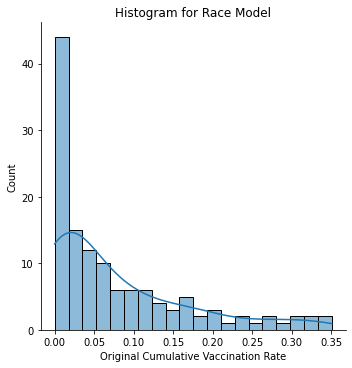

In [84]:
sns.displot(race_avg, x="percentages", kde=True, bins=20)
plt.title('Histogram for Race Model')
plt.xlabel('Original Cumulative Vaccination Rate')
plt.show()

Check box-cox transformed percentages for normality assumption using a histogram and qqplots. We can see that the results are much more normally distributed than the original distribution of percentages.

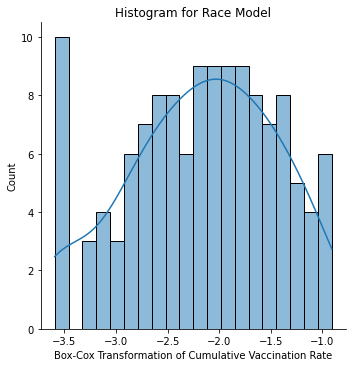

In [85]:
sns.displot(race_avg, x="box_cox", kde=True, bins=20)
plt.title('Histogram for Race Model')
plt.xlabel('Box-Cox Transformation of Cumulative Vaccination Rate')
plt.show()

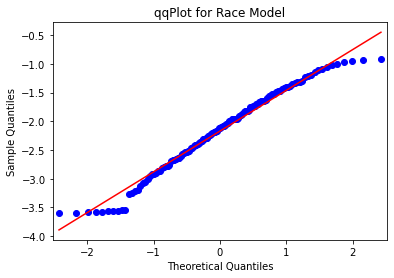

In [86]:
qqplot(race_avg['box_cox'],line='s')
plt.title('qqPlot for Race Model')
plt.show()

### GLM

Next, we will split the data into training and test sets and select the feature columns and outcome column. Since the datasets are fairly small, we will use 30% of the points as test points and 70% as training points so there are enough testing points. 

In [87]:
train, test = sklearn.model_selection.train_test_split(race_avg, test_size=.30, random_state=102)

X_cols = ['demographic_value']
y_col = 'box_cox'

X = train[X_cols]
y = train[y_col]

With the training data, we can fit a GLM with a Gaussian distribution family. 

In [88]:
model_race = smf.glm('box_cox ~ C(demographic_value, Treatment(reference="White"))', data=train).fit()
model_race.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                box_cox   No. Observations:                   90
Model:                            GLM   Df Residuals:                       83
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                         0.46346
Method:                          IRLS   Log-Likelihood:                -89.455
Date:                Sun, 09 May 2021   Deviance:                       38.467
Time:                        22:36:22   Pearson chi2:                     38.5
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          -2.1557      0.182    -11.848      0.000      -2.512      -1.799
C(demographic_value, Treatment(reference="White"))[T.American Indian or Alaska Native]             -0.3785      0.257     -1.471      0.141      -0.883       0.126
C(demographic_value, Treatment(reference="White"))[T.Asian]                                         0.1959      0.282      0.695      0.487      -0.357       0.748
C(demographic_value, Treatment(reference="White"))[T.Black or African American]                    -0.1443      0.253     -0.570      0.568      -0.640       0.352
C(demographic_value, Treatment(reference="White"))[T.Latino]                                       -0.1257      0.262     -0.479      0.632      -0.640       0.388
C(demographic_value, Treatment(reference="White"))[T.Multiracial]                                  -0.0131      0.291     -0.045      0.964      -0.583       0.557
C(demographic_value, Treatment(reference="White"))[T.Native Hawaiian or Other Pacific Islander]     0.3769      0.253      1.490      0.136      -0.119       0.873
===================================================================================================================================================================
"""

Finally, we can use the fitted model to predict outcomes using the test design matrix. We can then calculate the RMSE for both the training and test data to assess the performance of the model. 

In [89]:
train["glm_pred"] = model_race.predict(X)
test["glm_pred"] = model_race.predict(test[X_cols])

train_rmse = np.mean((train["glm_pred"] - train["box_cox"]) ** 2) ** 0.5
test_rmse = np.mean((test["glm_pred"] - test["box_cox"]) ** 2) ** 0.5

print("Training set error for glm:", train_rmse)
print("Test set error for glm:    ", test_rmse)

Training set error for glm: 0.6537706671746736
Test set error for glm:     0.7407620278762365


Using the coefficient values and the lambda value calculated earlier, we can transform the coefficients and standard error back into units consistent with the original data. 

In [51]:
# for coefficients
model_race.params
inv_boxcox([-2.155733, -0.378547, 0.195900, -0.144273, -0.125689, -0.013093, 0.376900], lambda_value)

array([0.03801184, 0.67047909, 1.21021646, 0.86310683, 0.87992781,
       0.98696899, 1.43132282])

In [90]:
# for standard errors 
# for coefficients
inv_boxcox([0.182, 0.257, 0.282, 0.253, 0.262, 0.291, 0.253], lambda_value)

array([1.19433151, 1.28186285, 1.31204565, 1.27708074, 1.28785873,
       1.32303644, 1.27708074])

### Random Forest

For a random forest, we first converted the categorical race data to numerical data via one-hot encoding. 

In [55]:
race_vax_dummies = pd.get_dummies(prefix='demographic_value', data=race_vax, drop_first=False)
race_vax_dummies = race_vax_dummies.drop(['administered_date', 'fully_vaccinated', 'cumulative_fully_vaccinated'], axis=1)

X_cols = ['demographic_value_American Indian or Alaska Native',
       'demographic_value_Asian',
       'demographic_value_Black or African American',
       'demographic_value_Latino', 
       'demographic_value_Multiracial',
       'demographic_value_Native Hawaiian or Other Pacific Islander',
       'demographic_value_White']
y_col = 'box_cox'

race_vax_dummies

percentages   box_cox  week  \
8     3.590215e-01 -0.892585    17   
9     1.911416e-01 -1.329056    17   
10    3.508309e-01 -0.909936    17   
13    1.932169e-01 -1.322199    17   
14    1.105310e-01 -1.651421    17   
...            ...       ...   ...   
2166  4.898443e-07 -3.565356    52   
2199  3.265629e-07 -3.572379    52   
2238  6.327156e-07 -3.560501    52   
2249  6.933870e-08 -3.593032    52   
2267  1.632814e-07 -3.582710    51   

      demographic_value_American Indian or Alaska Native  \
8                                                     0    
9                                                     0    
10                                                    0    
13                                                    0    
14                                                    0    
...                                                 ...    
2166                                                  0    
2199                                                  0    
2238                                                  0    
2249                                                  0    
2267                                                  0    

      demographic_value_Asian  demographic_value_Black or African American  \
8                           0                                            0   
9                           0                                            0   
10                          1                                            0   
13                          0                                            1   
14                          0                                            0   
...                       ...                                          ...   
2166                        1                                            0   
2199                        1                                            0   
2238                        0                                            0   
2249                        0                                            0   
2267                        1                                            0   

      demographic_value_Latino  demographic_value_Multiracial  \
8                            0                              0   
9                            1                              0   
10                           0                              0   
13                           0                              0   
14                           0                              1   
...                        ...                            ...   
2166                         0                              0   
2199                         0                              0   
2238                         0                              1   
2249                         0                              0   
2267                         0                              0   

      demographic_value_Native Hawaiian or Other Pacific Islander  \
8                                                     0             
9                                                     0             
10                                                    0             
13                                                    0             
14                                                    0             
...                                                 ...             
2166                                                  0             
2199                                                  0             
2238                                                  0             
2249                                                  0             
2267                                                  0             

      demographic_value_White  
8                           1  
9                           0  
10                          0  
13                          0  
14                          0  
...                       ...  
2166                        0  
2199                      

This data was then split into test and training sets as well, and specific columns were pulled out for the design matrix and outcomes. We then fit the training data to a random forest and then used this model to predict the outcomes of the test data. 

In [56]:
train, test = sklearn.model_selection.train_test_split(race_vax_dummies, test_size=.30, random_state=102)

forest_model_race = RandomForestRegressor(max_features=1)
X = train[X_cols]
y = train[y_col]

forest_model_race.fit(X, y)

train["forest_pred"] = forest_model_race.predict(X)
test["forest_pred"] = forest_model_race.predict(test[X_cols])

Finally, we can assess the performance of our model by calculating the RMSE. 

In [57]:
train_rmse = np.mean((train["forest_pred"] - train["box_cox"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["box_cox"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 0.5882644026377469
Test set error for random forest:     0.6055692663459198


## Sex

The exact same procedure that was used for building the models based on race was used for the models based on the sex demographic. First, we extracted rows from the entire vaccinations by demographic dataset for ones that recorded the sex demographic. Then, rates of vaccination for each group relative to their statewide population were calcuated. Finally, a box-cox transformation of these percentages was performed to normalize the data. 

In [58]:
sex_vax = dem_vax_partial[dem_vax_partial['demographic_value'].isin(['Male', 'Female'])]

sex_vax['percentages'] = np.where(sex_vax['demographic_value'] == 'Male', sex_vax['cumulative_fully_vaccinated'] / (.503*ca_pop), sex_vax['cumulative_fully_vaccinated'] / (.497*ca_pop))

sex_vax = sex_vax.drop(sex_vax[sex_vax['fully_vaccinated'] == 0].index)

sex_vax['week'] = sex_vax['administered_date'].dt.week
sex_vax['log_vax'] = np.log(sex_vax['fully_vaccinated'])
sex_vax['box_cox'] = stats.boxcox(sex_vax['percentages'])[0]

sex_vax = sex_vax.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

sex_avg = sex_vax.groupby(['demographic_value', 'week']).mean().reset_index()
sex_avg

demographic_value  week  fully_vaccinated  cumulative_fully_vaccinated  \
0             Female     1      10519.000000                 3.459386e+04   
1             Female     2      15511.142857                 1.547283e+05   
2             Female     3      12664.428571                 2.424094e+05   
3             Female     4      18445.714286                 3.570706e+05   
4             Female     5      29942.571429                 5.248564e+05   
5             Female     6      54011.714286                 8.318484e+05   
6             Female     7      56486.571429                 1.228140e+06   
7             Female     8      66705.857143                 1.657810e+06   
8             Female     9      62144.571429                 2.114532e+06   
9             Female    10      73860.714286                 2.575728e+06   
10            Female    11      72117.000000                 3.114333e+06   
11            Female    12      76217.428571                 3.607810e+06   
12            Female    13      85748.571429                 4.194957e+06   
13            Female    14     108994.285714                 4.894075e+06   
14            Female    15      89869.428571                 5.592001e+06   
15            Female    16      93523.142857                 6.233172e+06   
16            Female    17      74474.857143                 6.827143e+06   
17            Female    51          1.000000                 1.500000e+00   
18            Female    52          1.000000                 4.000000e+00   
19            Female    53          3.666667                 1.600000e+01   
20              Male     1       7106.142857                 2.425029e+04   
21              Male     2       8508.000000                 9.497443e+04   
22              Male     3       6756.714286                 1.414384e+05   
23              Male     4      10146.428571                 2.047820e+05   
24              Male     5      16939.857143                 2.995356e+05   
25              Male     6      34332.285714                 4.859933e+05   
26              Male     7      41667.571429                 7.649814e+05   
27              Male     8      51437.285714                 1.090678e+06   
28              Male     9      49087.428571                 1.449126e+06   
29              Male    10      58031.714286                 1.811344e+06   
30              Male    11      58431.142857                 2.243220e+06   
31              Male    12      61107.285714                 2.640884e+06   
32              Male    13      74295.571429                 3.129993e+06   
33              Male    14     103361.142857                 3.772354e+06   
34              Male    15      84752.142857                 4.436143e+06   
35              Male    16      90262.714286                 5.047997e+06   
36              Male    17      73586.428571                 5.629514e+06   
37              Male    52          1.000000                 1.500000e+00   
38              Male    53          2.250000                 7.250000e+00   

     percentages    log_vax   box_cox  
0   1.761616e-03   8.300116 -2.954377  
1   7.879195e-03   9.364023 -2.586037  
2   1.234416e-02   9.286303 -2.468598  
3   1.818303e-02   9.648292 -2.355959  
4   2.672715e-02  10.209966 -2.231125  
5   4.236004e-02  10.834516 -2.062044  
6   6.254032e-02  10.848412 -1.897706  
7   8.442029e-02  11.051363 -1.758498  
8   1.076779e-01  10.985307 -1.635850  
9   1.311632e-01  11.144405 -1.530443  
10  1.585905e-01  11.128610 -1.422585  
11  1.837197e-01  11.193075 -1.335089  
12  2.136189e-01  11.305010 -1.241354  
13  2.492199e-01  11.560969 -1.141262  
14  2.847603e-01  11.351374 -1.050621  
15  3.174105e-01  11.378313 -0.974355  
16  3.476571e-01  11.082119 -0.908385  
17  7.638418e-08   0.000000 -3.375420  
18  2.036911e-07   0.000000 -3.366045  
19  8.147646e-07   1.194506 -3.348232  
20  1.220162e-03   8.026845 -2.996774  
21  4.778672e-03   8.716045 -2.697032  
22

For later interpretation of the data, the box_cox function also returns the lambda value used to maximze the log-likelihood function as the second output. This can be used later to invert the transformation so we can interpret the coefficients of the model.

In [91]:
lambda_value = stats.boxcox(sex_vax['percentages'])[1]
lambda_value

0.29388912362548913

### Check Normality Assumption

Let's visualize what will be denoted as the "original" distribution of percentages. Unfortunately, it is no where near being normally distributed. This is a problem, considering we intend to use the Gaussian GLM, which assumes normality.

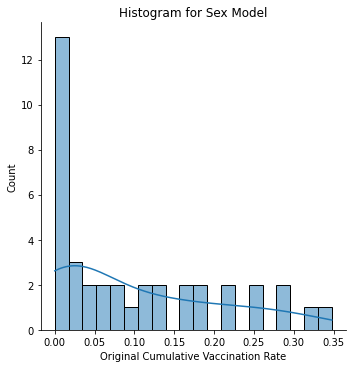

In [60]:
sns.displot(sex_avg, x="percentages", kde=True, bins=20)
plt.title('Histogram for Sex Model')
plt.xlabel('Original Cumulative Vaccination Rate')
plt.show()

Check box-cox transformed percentages for normality assumption using a histogram and qqplots. We can see that the results are much more normally distributed than the original distribution of percentages.

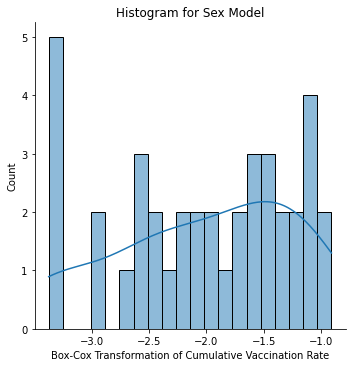

In [61]:
sns.displot(sex_avg, x="box_cox", kde=True, bins=20)
plt.title('Histogram for Sex Model')
plt.xlabel('Box-Cox Transformation of Cumulative Vaccination Rate')
plt.show()

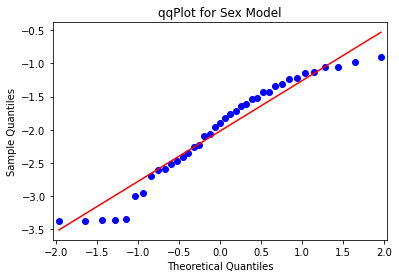

In [62]:
qqplot(sex_avg['box_cox'],line='s')
plt.title('qqPlot for Sex Model')
plt.show()

### GLM

Next, we will split the data into training and test sets and select the feature columns and outcome column. Since the datasets are fairly small, we will use 30% of the points as test points and 70% as training points so there are enough testing points.

In [63]:
train, test = sklearn.model_selection.train_test_split(sex_avg, test_size=.30, random_state=102)

X_cols = ['demographic_value']
y_col = 'box_cox'

X = train[X_cols]
y = train[y_col]

With the training data, we can fit a GLM with a Gaussian distribution family.

In [64]:
model_sex = smf.glm('box_cox ~ demographic_value', data=train).fit()
model_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                box_cox   No. Observations:                   27
Model:                            GLM   Df Residuals:                       25
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.56591
Method:                          IRLS   Log-Likelihood:                -29.587
Date:                Sun, 09 May 2021   Deviance:                       14.148
Time:                        18:54:58   Pearson chi2:                     14.1
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.9277      0.217     -8.877      0.000      -2.353      -1.502
demographic_value[T.Male]    -0.1103      0.291     -0.379      0.705      -0.681       0.461
=============================================================================================
"""

Finally, we can use the fitted model to predict outcomes using the test design matrix. We can then calculate the RMSE for both the training and test data to assess the performance of the model.

In [65]:
train["glm_pred"] = model_sex.predict(X)
test["glm_pred"] = model_sex.predict(test[X_cols])

train_rmse = np.mean((train["glm_pred"] - train["box_cox"]) ** 2) ** 0.5
test_rmse = np.mean((test["glm_pred"] - test["box_cox"]) ** 2) ** 0.5

print("Training set error for glm:", train_rmse)
print("Test set error for glm:    ", test_rmse)

Training set error for glm: 0.7238719783744121
Test set error for glm:     0.8367683292246311


Using the coefficient values and the lambda value calculated earlier, we can transform the coefficients and standard errors back into units consistent with the original data.

In [66]:
# coefficients
model_sex.params
inv_boxcox([-1.9277, -0.1103], lambda_value)

array([0.05817022, 0.89393042])

In [93]:
# standard error
inv_boxcox([0.217, 0.291], lambda_value)

array([1.2341239 , 1.32210273])

### Random Forest

For a random forest, we first converted the categorical race data to numerical data via one-hot encoding.

In [67]:
sex_vax_dummies = pd.get_dummies(prefix='demographic_value', data=sex_vax)
sex_vax_dummies = sex_vax_dummies.drop(['administered_date', 'percentages', 'cumulative_fully_vaccinated', 'log_vax'], axis=1)

X_cols = ['demographic_value']
y_col = 'box_cox'

sex_vax_dummies

This data was then split into test and training sets as well, and specific columns were pulled out for the design matrix and outcomes. We then fit the training data to a random forest and then used this model to predict the outcomes of the test data.

In [68]:
train["glm_pred"] = model_sex.predict(X)
test["glm_pred"] = model_sex.predict(test[X_cols])

Finally, we can assess the performance of our model by calculating the RMSE.

In [69]:
train_rmse = np.mean((train["glm_pred"] - train["box_cox"]) ** 2) ** 0.5
test_rmse = np.mean((test["glm_pred"] - test["box_cox"]) ** 2) ** 0.5

print("Training set error for glm:", train_rmse)
print("Test set error for glm:    ", test_rmse)

Training set error for glm: 0.7238719783744121
Test set error for glm:     0.8367683292246311


## Age

In the following cells, we will train a GLM and random forest with age as a categorical predictor variable and cummulative vaccination rate as the outcome. First, we extracted rows from the entire vaccinations by demographic dataset for ones that recorded the race demographic. Then, rates of vaccination for each group relative to their statewide population were calcuated. Finally, a box-cox transformation of these percentages was performed to normalize the data.

In [70]:
age_vax = dem_vax_partial[dem_vax_partial['demographic_value'].isin(["0-17", "18-49", "50-64", "65+"])]

def age_percents(s):
    if s['demographic_value'] == '0-17':
        return s['cumulative_fully_vaccinated'] / 8894641.0
    elif s['demographic_value'] == '18-49':
        return s['cumulative_fully_vaccinated'] / 17528506.0
    elif s['demographic_value'] == '50-64':
        return s['cumulative_fully_vaccinated'] / 7250961.0
    elif s['demographic_value'] == '65+':
        return s['cumulative_fully_vaccinated'] / 5838115.0

age_vax['percentages'] = age_vax.apply(age_percents, axis=1)

age_vax = age_vax.drop(age_vax[age_vax['fully_vaccinated'] == 0].index)


age_vax['week'] = age_vax['administered_date'].dt.week
age_vax['log_vax'] = np.log(age_vax['fully_vaccinated'])
age_vax['box_cox'] = stats.boxcox(age_vax['percentages'])[0]

age_vax = age_vax.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
age_vax

age_avg = age_vax.groupby(['demographic_value', 'week']).mean().reset_index()
age_avg

demographic_value  week  fully_vaccinated  cumulative_fully_vaccinated  \
0               0-17     1          3.600000                 9.200000e+00   
1               0-17     2          9.142857                 6.242857e+01   
2               0-17     3         18.142857                 1.745714e+02   
3               0-17     4         24.166667                 3.046667e+02   
4               0-17     5         54.142857                 5.965714e+02   
..               ...   ...               ...                          ...   
69               65+    14      28125.285714                 3.657342e+06   
70               65+    15      17662.285714                 3.809443e+06   
71               65+    16      14423.142857                 3.918493e+06   
72               65+    17      10268.285714                 4.003373e+06   
73               65+    53          1.000000                 1.500000e+00   

     percentages    log_vax   box_cox  
0   1.034331e-06   0.916993 -5.546946  
1   7.018672e-06   1.879115 -5.273070  
2   1.962659e-05   2.314036 -5.106076  
3   3.425283e-05   3.119784 -5.002761  
4   6.707088e-05   3.906447 -4.870852  
..           ...        ...       ...  
69  6.264595e-01  10.160472 -0.450474  
70  6.525125e-01   9.677901 -0.412513  
71  6.711915e-01   9.475339 -0.386104  
72  6.857305e-01   9.020687 -0.365969  
73  2.569322e-07   0.000000 -5.642715  

[74 rows x 7 columns]

For later interpretation of the data, the box_cox function also returns the lambda value used to maximze the log-likelihood function as the second output. This can be used later to invert the transformation so we can interpret the coefficients of the model.



In [94]:
lambda_value = stats.boxcox(sex_vax['percentages'])[1]
lambda_value

0.29388912362548913

### Check Normality Assumption

Let's visualize what will be denoted as the "original" distribution of percentages. Unfortunately, it is no where near being normally distributed. This is a problem, considering we intend to use the Gaussian GLM, which assumes normality.

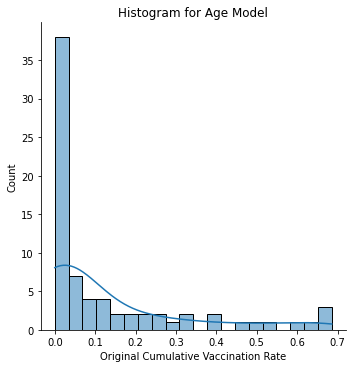

In [72]:
sns.displot(age_avg, x="percentages", kde=True, bins=20)
plt.title('Histogram for Age Model')
plt.xlabel('Original Cumulative Vaccination Rate')
plt.show()

Check box-cox transformed percentages for normality assumption using a histogram and qqplots. We can see that the results are much more normally distributed than the original distribution of percentages.

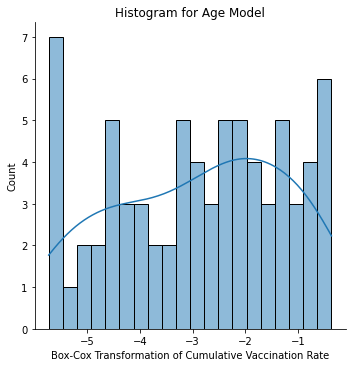

In [73]:
sns.displot(age_avg, x="box_cox", kde=True, bins=20)
plt.title('Histogram for Age Model')
plt.xlabel('Box-Cox Transformation of Cumulative Vaccination Rate')
plt.show()

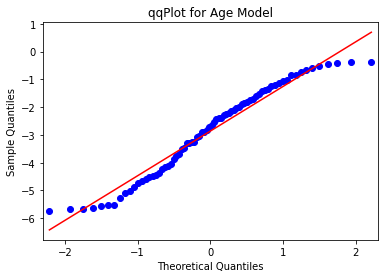

In [74]:
qqplot(age_avg['box_cox'],line='s')
plt.title('qqPlot for Age Model')
plt.show()

### GLM

Next, we will split the data into training and test sets and select the feature columns and outcome column. Since the datasets are fairly small, we will use 30% of the points as test points and 70% as training points so there are enough testing points.

In [75]:
train, test = sklearn.model_selection.train_test_split(age_avg, test_size=.30, random_state=102)

X_cols = ['demographic_value']
y_col = 'box_cox'

X = train[X_cols]
y = train[y_col]

With the training data, we can fit a GLM with a Gaussian distribution family.

In [76]:
model_age = smf.glm('box_cox ~ demographic_value', data=train).fit()
model_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                box_cox   No. Observations:                   51
Model:                            GLM   Df Residuals:                       47
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.6365
Method:                          IRLS   Log-Likelihood:                -82.844
Date:                Sun, 09 May 2021   Deviance:                       76.916
Time:                        18:55:41   Pearson chi2:                     76.9
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.5757      0.386    -11.863      0.000      -5.332      -3.820
demographic_value[T.18-49]     2.0598      0.534      3.857      0.000       1.013       3.106
demographic_value[T.50-64]     2.1318      0.508      4.198      0.000       1.136       3.127
demographic_value[T.65+]       2.6232      0.524      5.005      0.000       1.596       3.650
==============================================================================================
"""

Finally, we can use the fitted model to predict outcomes using the test design matrix. We can then calculate the RMSE for both the training and test data to assess the performance of the model.

In [77]:
train["glm_pred"] = model_age.predict(X)
test["glm_pred"] = model_age.predict(test[X_cols])

train_rmse = np.mean((train["glm_pred"] - train["box_cox"]) ** 2) ** 0.5
test_rmse = np.mean((test["glm_pred"] - test["box_cox"]) ** 2) ** 0.5

print("Training set error for glm:", train_rmse)
print("Test set error for glm:    ", test_rmse)

Training set error for glm: 1.2280701664725016
Test set error for glm:     1.5079310007434776


Using the coefficient and standard error values and the lambda value calculated earlier, we can transform the coefficients and standard errors back into units consistent with the original data.

In [78]:
model_age.params
inv_boxcox([-4.5757, 2.0598, 2.1318, 2.6232], lambda_value)

array([       nan, 5.00591147, 5.2340034 , 6.99102559])

In [97]:
inv_boxcox([0.386, 0.534, 0.508, 0.524], lambda_value)

array([1.44142535, 1.64217761, 1.60556464, 1.62802669])

### Random Forest

For a random forest, we first converted the categorical race data to numerical data via one-hot encoding.

In [79]:
age_vax_dummies = pd.get_dummies(prefix='demographic_value', data=age_vax)
age_vax_dummies = age_vax_dummies.drop(['administered_date', 'fully_vaccinated', 'cumulative_fully_vaccinated'], axis=1)

X_cols = ['demographic_value_0-17', 'demographic_value_18-49', 'demographic_value_50-64', 'demographic_value_65+']
y_col = 'box_cox'

age_vax_dummies

percentages  week    log_vax   box_cox  demographic_value_0-17  \
0     2.986599e-01    17   9.840548 -1.097373                       0   
1     6.896560e-01    17   7.265430 -0.360586                       0   
2     4.837250e-01    17   9.274254 -0.685090                       0   
3     1.011587e-02    17   7.387709 -3.238489                       1   
17    2.975885e-01    17  10.923868 -1.100326                       0   
...            ...   ...        ...       ...                     ...   
2191  1.379128e-07    52   0.000000 -5.689018                       0   
2224  2.281997e-07    52   0.000000 -5.648558                       0   
2241  1.711498e-07    52   0.000000 -5.672075                       0   
2258  1.140999e-07    51   0.000000 -5.703410                       0   
2275  5.704993e-08    51   0.000000 -5.752429                       0   

      demographic_value_18-49  demographic_value_50-64  demographic_value_65+  
0                           1                        0                      0  
1                           0                        0                      1  
2                           0                        1                      0  
3                           0                        0                      0  
17                          1                        0                      0  
...                       ...                      ...                    ...  
2191                        0                        1                      0  
2224                        1                        0                      0  
2241                        1                        0                      0  
2258                        1                        0                      0  
2275                        1                        0                      0  

[494 rows x 8 columns]

This data was then split into test and training sets as well, and specific columns were pulled out for the design matrix and outcomes. We then fit the training data to a random forest and then used this model to predict the outcomes of the test data.

In [80]:
train, test = sklearn.model_selection.train_test_split(age_vax_dummies, test_size=.20, random_state=102)


forest_model_age = RandomForestRegressor(max_features=1)
X = train[X_cols]
y = train[y_col]

forest_model_age.fit(X, y)

train["forest_pred"] = forest_model_age.predict(X)
test["forest_pred"] = forest_model_age.predict(test[X_cols])

Finally, we can assess the performance of our model by calculating the RMSE.

In [81]:
train_rmse = np.mean((train["forest_pred"] - train["box_cox"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["box_cox"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 1.141972386353924
Test set error for random forest:     1.2577472629957613


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87ef556b-5226-45be-a227-f17917caca19' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>